# IF3170 Artificial Intelligence | Tugas Besar 1
Notebook ini digunakan untuk pengujian terhadap implementasi model FFNN.

Nomor Kelompok: 57

Anggota Kelompok:
- Aland Mulia Pratama (13522124)
- Christian Justin Hendrawan (13522135)
- Albert Ghazaly (13522150)

In [68]:
# Import libararies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from ffnn.model import FFNN
plt.style.use('ggplot')
from sklearn.metrics import f1_score, accuracy_score
from sklearn.neural_network import MLPClassifier

# 1. Memuat Dataset MNIST_784

Dataset **MNIST_784** adalah kumpulan data yang terdiri dari 70.000 gambar tulisan tangan angka (digit) dari 0 hingga 9 dengan dimensi 28x28 piksel yang telah diratakan menjadi vektor berdimensi 784. Dataset ini sering digunakan dalam bidang **computer vision** dan pembelajaran mesin untuk pengenalan pola dan klasifikasi.

Proses pengolahan data dilakukan melalui langkah-langkah berikut:

1. **Pembagian Data (Data Split)**

    Dataset dibagi menjadi data latih (training data) dan data uji (test data). Pembagian ini dilakukan dengan memisahkan 10.000 sampel sebagai data uji, sementara sisanya digunakan untuk pelatihan. Proses pembagian menggunakan fungsi train_test_split dengan rasio test_size=10,000, memastikan bahwa data uji tetap terdistribusi secara acak dan representatif.

2. **Normalisasi Data (Data Normalization)**

    Untuk meningkatkan performa model, data fitur (pixel values) dinormalisasi ke rentang [0,1] dengan membagi setiap nilai piksel dengan 255. Hal ini dilakukan untuk mengurangi skala besar pada data asli, sehingga mempercepat proses pembelajaran dan meningkatkan stabilitas optimasi.

3. **Pengkodean Label (One-Hot Encoding)**

    Target label, yang awalnya berupa integer (0-9), diubah menjadi representasi one-hot encoding. Proses ini dilakukan dengan menggunakan OneHotEncoder dari scikit-learn, di mana setiap label dikodekan sebagai vektor biner berdimensi 10. Contohnya, label 2 akan diubah menjadi [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]. Teknik ini sangat penting dalam arsitektur jaringan saraf untuk memungkinkan model memprediksi probabilitas pada setiap kelas.

In [46]:
def load_mnist():
    print("Loading MNIST_784 dataset...")
    
    # Ambil dataset dari OpenML
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    X = mnist.data.astype('float32')
    y = mnist.target.astype('int')
    
    # Normalisasi data
    X = X / 255.0
    
    # Split dataset menjadi training dan testing
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=10000, random_state=42)
    
    # Reshape data untuk satu dimensi
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    
    # One-hot encoding untuk label
    encoder = OneHotEncoder(sparse_output=False)
    y_train = encoder.fit_transform(y_train)
    y_test = encoder.transform(y_test)
    
    print(f"Dataset loaded: {X_train.shape[0]} training samples, "
          f"{X_test.shape[0]} test samples")
    print(f"Input dimension: {X_train.shape[1]}")
    print(f"Output classes: {y_train.shape[1]}")
    
    return X_train, X_test, y_train, y_test


# 2. Analisis Data & Eksplorasi (EDA)

Pada bagian ini, kita melakukan **visualisasi awal data** untuk memahami bentuk dan struktur dataset MNIST yang digunakan. Visualisasi ini bertujuan untuk memastikan bahwa data yang akan kita proses memiliki representasi yang benar dan sesuai dengan tujuan analisis.

Dataset MNIST terdiri dari gambar angka tulisan tangan dari **0 hingga 9**, dengan ukuran piksel 28x28. Setiap angka direpresentasikan dalam bentuk **array berdimensi 784** yang dapat dirangkai ulang menjadi gambar aslinya.

Visualisasi dilakukan dengan menampilkan beberapa contoh data dalam bentuk gambar angka bersama dengan **label yang sesuai**. Gambar-gambar ini menunjukkan variasi dari setiap digit dan memberikan gambaran tentang distribusi data. Proses ini membantu kita memastikan bahwa **data piksel benar-benar membentuk angka**, serta memahami tantangan dalam membangun model FFNN untuk memprediksi **angka berdasarkan nilai pikselnya**.

In [47]:
def visualize_examples(X, y_onehot, n_examples=5):
    plt.figure(figsize=(15, 3))
    
    y = np.argmax(y_onehot, axis=1)
    
    for i in range(n_examples):
        plt.subplot(1, n_examples, i+1)
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title(f"Label: {y[i]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Loading MNIST_784 dataset...
Dataset loaded: 60000 training samples, 10000 test samples
Input dimension: 784
Output classes: 10


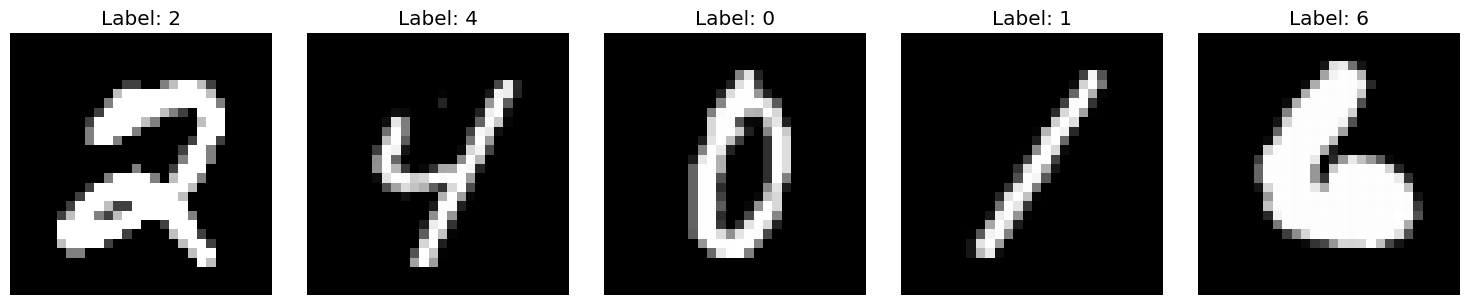

In [48]:
# Load dataset
X_train, X_test, y_train, y_test = load_mnist()

# Lakukan visualisasi contoh data
visualize_examples(X_train, y_train)

# 3. Pengujian Terhadap Implementasi FFNN (Feed Forward Neural Network)

Analisis ini bertujuan mengevaluasi pengaruh berbagai hyperparameter pada kinerja model FFNN. Pertama, dilakukan analisis pengaruh jumlah layer (depth) dan jumlah neuron per layer (width) terhadap hasil prediksi dan grafik loss pelatihan. Kedua, diuji pengaruh fungsi aktivasi hidden layer (kecuali softmax) pada hasil prediksi, grafik loss, serta distribusi bobot dan gradien. Ketiga, dilakukan analisis variasi learning rate untuk membandingkan hasil prediksi, grafik loss, dan distribusi bobot atau gradien. Keempat, pengaruh metode inisialisasi bobot dianalisis dengan membandingkan hasil prediksi, grafik loss, serta distribusi parameter. Terakhir, hasil prediksi model dibandingkan dengan library sklearn MLP menggunakan hyperparameter yang sama untuk menilai perbedaan kinerja.

In [49]:
def train_and_evaluate(X_train, X_test, y_train, y_test, 
                      hidden_layers, width_per_layer, 
                      hidden_activation='relu',    
                      output_activation='softmax',  
                      weight_initializer='normal', 
                      initializer_params=None,     
                      epochs=10, learning_rate=0.01, batch_size=128,
                      verbose=1):
    
    input_size = X_train.shape[1]  
    output_size = y_train.shape[1] 
    
    # Default initializer params jika tidak disediakan
    if initializer_params is None:
        initializer_params = {'std': 0.1}
    
    start_time = time.time()
    
    # Buat model
    model = FFNN(loss='categorical_crossentropy')
    
    # Tambahkan input layer
    if isinstance(width_per_layer, list):
        first_layer_width = width_per_layer[0]
    else:
        first_layer_width = width_per_layer
        
    model.add(input_size=input_size, output_size=first_layer_width, 
             activation=hidden_activation, 
             weight_initializer=weight_initializer, 
             **initializer_params)
    
    # Tambahkan hidden layers
    for i in range(1, hidden_layers):
        if isinstance(width_per_layer, list):
            prev_width = width_per_layer[i-1]
            current_width = width_per_layer[i]
        else:
            prev_width = width_per_layer
            current_width = width_per_layer
            
        model.add(input_size=prev_width, output_size=current_width,
                 activation=hidden_activation,
                 weight_initializer=weight_initializer, 
                 **initializer_params)
    
    # Tambahkan output layer dengan aktivasi yang ditentukan
    if isinstance(width_per_layer, list):
        last_hidden_width = width_per_layer[-1]
    else:
        last_hidden_width = width_per_layer
        
    model.add(input_size=last_hidden_width, output_size=output_size,
             activation=output_activation, 
             weight_initializer=weight_initializer, 
             **initializer_params)
    
    # Menunjukkan ringkasan model
    print(f"\nTraining model with {hidden_layers} hidden layers, width: {width_per_layer}")
    print(f"Activation: {hidden_activation} (hidden) | {output_activation} (output)")
    print(f"Initializer: {weight_initializer} with params {initializer_params}")
    model.summary()
    
    # Melakukan training model
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        learning_rate=learning_rate,
        epochs=epochs,
        validation_data=(X_test, y_test),
        verbose=verbose,
    )
    
    # Hitung waktu training
    training_time = time.time() - start_time
    
    # Evaluasi model
    y_pred = model.forward(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    accuracy = np.mean(y_pred_classes == y_test_classes)
    
    # Tampilkan informasi akhir hanya jika verbose > 0
    if verbose > 0:
        print(f"Test accuracy: {accuracy:.4f}")
        print(f"Training time: {training_time:.2f} seconds")
    
    return {
        'model': model,
        'history': history,
        'accuracy': accuracy,
        'training_time': training_time,
        'depth': hidden_layers,
        'width': width_per_layer,
        'hidden_activation': hidden_activation,
        'output_activation': output_activation,
        'weight_initializer': weight_initializer,
        'initializer_params': initializer_params
    }

In [50]:
def calculate_f1(y_true, y_pred):
    y_true_classes = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    return f1_score(y_true_classes, y_pred_classes, average='weighted')

In [51]:
def plot_training_history_and_accuracy(history, model, X_test, y_test):
    # Plot training dan validation loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Evaluasi akurasi pada test set
    print("\nEvaluating on test set...")
    y_pred = model.forward(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    accuracy = np.mean(y_pred_classes == y_test_classes)

    # Plot akurasi
    plt.subplot(1, 2, 2)
    plt.bar(['Accuracy'], [accuracy], color='skyblue')
    plt.title(f'Test Accuracy: {accuracy:.4f}')
    plt.ylim(0, 1)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


In [52]:
def visualize_predictions(model, X_test, y_test, n_examples=10):
    # Secara acak ambil contoh dari test set
    sample_indices = np.random.choice(len(X_test), n_examples, replace=False)
    X_samples = X_test[sample_indices]
    y_true_samples = np.argmax(y_test[sample_indices], axis=1)

    # Ambil prediksi pada contoh yang diambil
    y_pred_samples = model.forward(X_samples)
    y_pred_samples_classes = np.argmax(y_pred_samples, axis=1)

    # Visualisasi contoh dan prediksi
    plt.figure(figsize=(15, 4))
    for i in range(n_examples):
        plt.subplot(2, n_examples // 2, i + 1)
        plt.imshow(X_samples[i].reshape(28, 28), cmap='gray')

        color = 'green' if y_pred_samples_classes[i] == y_true_samples[i] else 'red'

        plt.title(f"True: {y_true_samples[i]}\nPred: {y_pred_samples_classes[i]}", 
                  color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [53]:
subset_size = 15000  
X_train_subset = X_train[:subset_size]
y_train_subset = y_train[:subset_size]

print("Creating and training a FFNN model...")
# Train dengan arsitektur dan parameter yang dioptimalkan
results = train_and_evaluate(
    X_train_subset, X_test, y_train_subset, y_test,
    hidden_layers=2,              
    width_per_layer=[128, 64],    
    hidden_activation='relu',     
    output_activation='softmax',  
    weight_initializer='he',      
    initializer_params={},      
    epochs=20,
    learning_rate=0.01,
    batch_size=128,
    verbose=1             
)

# Ambil model dan history hasil training
model = results['model']
history = results['history']

Creating and training a FFNN model...

Training model with 2 hidden layers, width: [128, 64]
Activation: relu (hidden) | softmax (output)
Initializer: he with params {}
Neural Network Architecture Summary
Total layers: 3

Layer Details:
--------------
Input shape: (784)
  Layer 1: 784 → 128 | Activation: ReLU | Parameters: 100480
  Layer 2: 128 → 64 | Activation: ReLU | Parameters: 8256
  Layer 3: 64 → 10 | Activation: Softmax | Parameters: 650

Total trainable parameters: 109386
Epoch 1/20 - loss: 1.9825, val_loss: 1.5828
Epoch 2/20 - loss: 1.2484, val_loss: 0.9765
Epoch 3/20 - loss: 0.8216, val_loss: 0.7060
Epoch 4/20 - loss: 0.6295, val_loss: 0.5779
Epoch 5/20 - loss: 0.5321, val_loss: 0.5051
Epoch 6/20 - loss: 0.4745, val_loss: 0.4582
Epoch 7/20 - loss: 0.4354, val_loss: 0.4266
Epoch 8/20 - loss: 0.4066, val_loss: 0.4041
Epoch 9/20 - loss: 0.3854, val_loss: 0.3855
Epoch 10/20 - loss: 0.3680, val_loss: 0.3694
Epoch 11/20 - loss: 0.3528, val_loss: 0.3578
Epoch 12/20 - loss: 0.3404, v


Evaluating on test set...


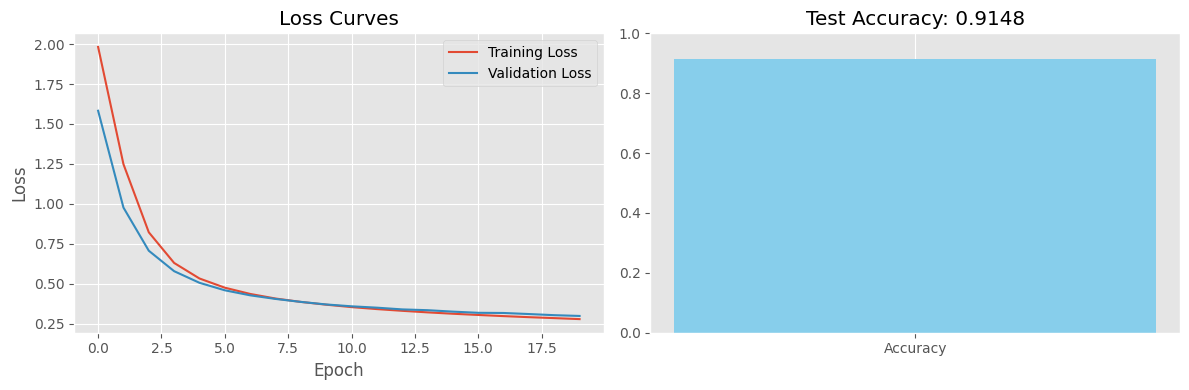

In [54]:
# Plot history training dan akurasi
plot_training_history_and_accuracy(history, model, X_test, y_test)


Visualizing network structure...
Adding edges with weights:


Draw network
Normalize weights to map to colors
Draw edges
Draw edge labels
Draw nodes
Draw labels
Draw legend


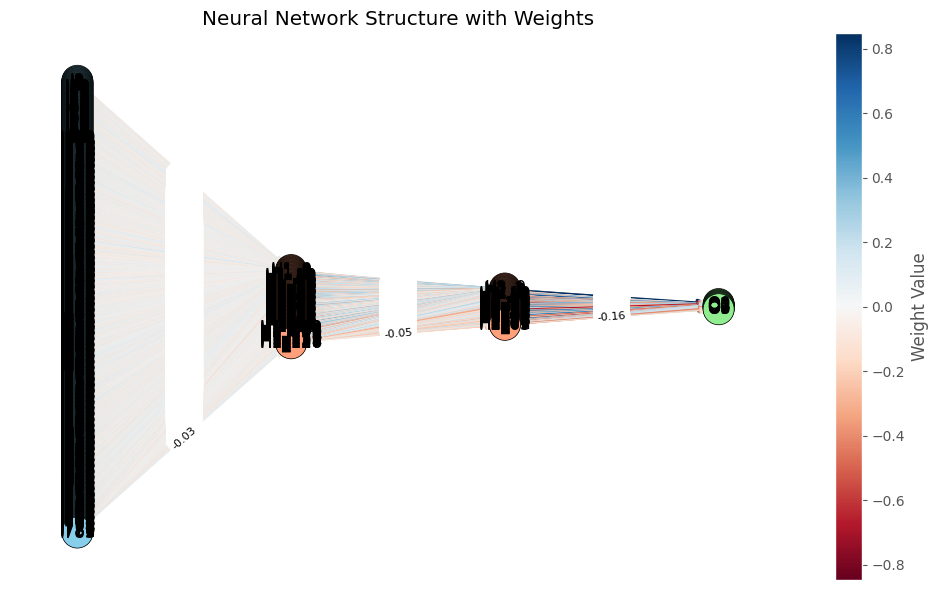

In [21]:
print("\nVisualizing network structure...")
model.visualize_network(figsize=(10, 6))


Visualizing weight distributions...


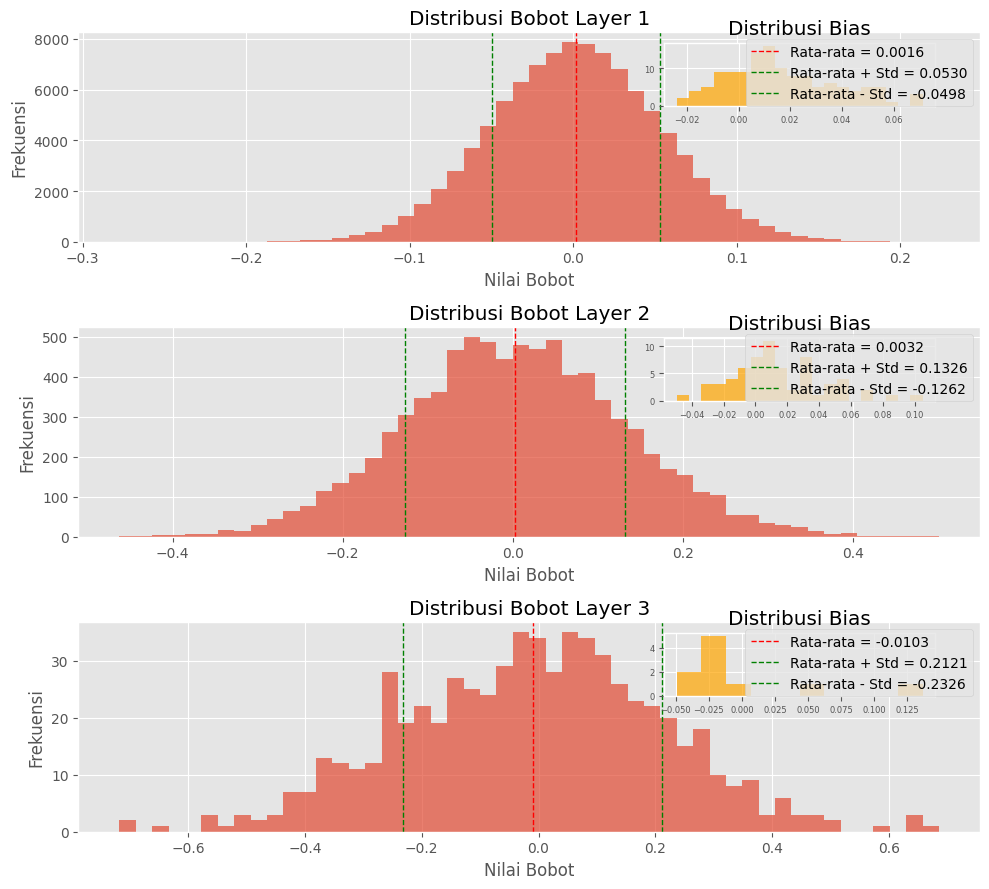

In [55]:
print("\nVisualizing weight distributions...")
model.visualize_weight_distribution()


Visualizing gradient distributions...


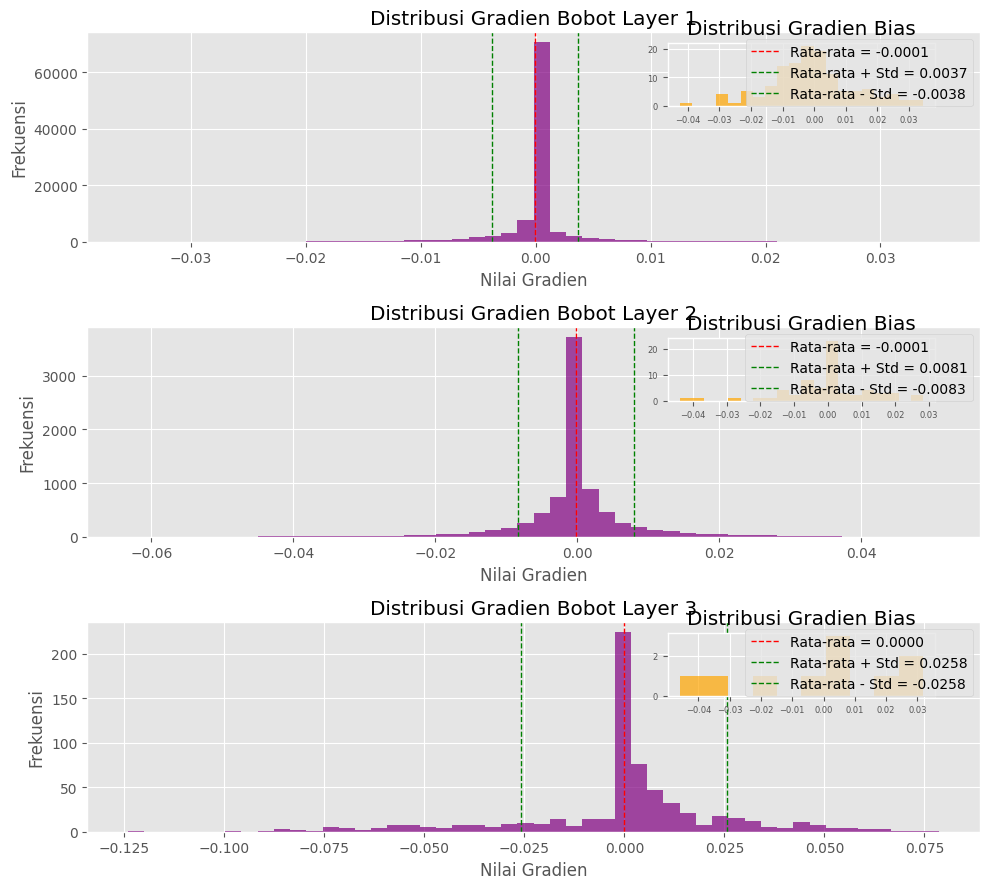

In [56]:
print("\nVisualizing gradient distributions...")
model.visualize_gradient_distribution()


Visualizing model predictions...


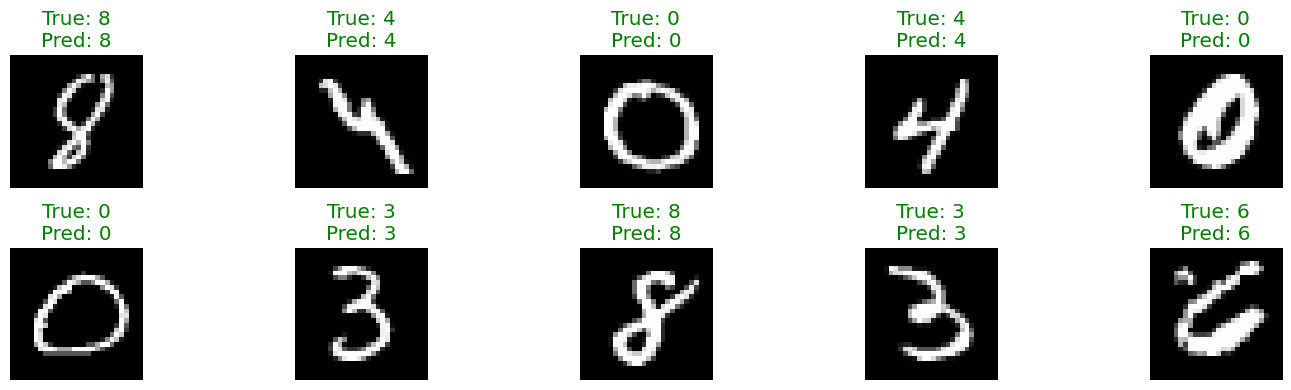

In [57]:
# Visualisasi prediksi
print("\nVisualizing model predictions...")
visualize_predictions(model, X_test, y_test, n_examples=10)

## a) Pengaruh depth (banyak layer) dan width (banyak neuron per layer)
Pada analisis ini, model FFNN akan diuji dengan 3 variasi kombinasi width (jumlah neuron per layer) dengan jumlah layer (depth) tetap, serta 3 variasi kombinasi depth (jumlah layer) dengan jumlah neuron (width) pada setiap layer tetap. Tujuan dari analisis ini adalah untuk:
- Membandingkan hasil akhir prediksi dari setiap variasi kombinasi depth dan width.
- Membandingkan grafik loss selama pelatihan untuk menilai pengaruh konfigurasi arsitektur terhadap proses konvergensi model.

### Pengujian Variasi Width (dengan Depth Tetap = 2)

In [58]:
print("==== ANALISIS PENGARUH WIDTH (JUMLAH NEURON) ====")

# 1. Model dengan width kecil
print("\n[Test 1] Model sempit: 32-16 neuron")
results_width_small = train_and_evaluate(
    X_train_subset, X_test, y_train_subset, y_test,
    hidden_layers=2,              
    width_per_layer=[32, 16],
    hidden_activation='relu',
    weight_initializer='he',
    epochs=15,
    learning_rate=0.01,
    batch_size=128
)
# Hitung F1 score
y_pred = results_width_small['model'].forward(X_test)
results_width_small['f1_score'] = calculate_f1(y_test, y_pred)
print(f"F1 Score: {results_width_small['f1_score']:.4f}")

# 2. Model dengan width sedang
print("\n[Test 2] Model sedang: 64-32 neuron")
results_width_medium = train_and_evaluate(
    X_train_subset, X_test, y_train_subset, y_test,
    hidden_layers=2,              
    width_per_layer=[64, 32],
    hidden_activation='relu',
    weight_initializer='he',
    epochs=15,
    learning_rate=0.01,
    batch_size=128
)
# Hitung F1 score
y_pred = results_width_medium['model'].forward(X_test)
results_width_medium['f1_score'] = calculate_f1(y_test, y_pred)
print(f"F1 Score: {results_width_medium['f1_score']:.4f}")

# 3. Model dengan width besar
print("\n[Test 3] Model lebar: 128-64 neuron")
results_width_large = train_and_evaluate(
    X_train_subset, X_test, y_train_subset, y_test,
    hidden_layers=2,              
    width_per_layer=[128, 64],
    hidden_activation='relu',
    weight_initializer='he',
    epochs=15,
    learning_rate=0.01,
    batch_size=128
)
# Hitung F1 score
y_pred = results_width_large['model'].forward(X_test)
results_width_large['f1_score'] = calculate_f1(y_test, y_pred)
print(f"F1 Score: {results_width_large['f1_score']:.4f}")

# Bandingkan hasil width
width_results = [
    results_width_small,
    results_width_medium,
    results_width_large
]

==== ANALISIS PENGARUH WIDTH (JUMLAH NEURON) ====

[Test 1] Model sempit: 32-16 neuron

Training model with 2 hidden layers, width: [32, 16]
Activation: relu (hidden) | softmax (output)
Initializer: he with params {'std': 0.1}
Neural Network Architecture Summary
Total layers: 3

Layer Details:
--------------
Input shape: (784)
  Layer 1: 784 → 32 | Activation: ReLU | Parameters: 25120
  Layer 2: 32 → 16 | Activation: ReLU | Parameters: 528
  Layer 3: 16 → 10 | Activation: Softmax | Parameters: 170

Total trainable parameters: 25818
Epoch 1/15 - loss: 2.1164, val_loss: 1.9022
Epoch 2/15 - loss: 1.7360, val_loss: 1.5578
Epoch 3/15 - loss: 1.4162, val_loss: 1.2560
Epoch 4/15 - loss: 1.1338, val_loss: 0.9902
Epoch 5/15 - loss: 0.8911, val_loss: 0.7908
Epoch 6/15 - loss: 0.7300, val_loss: 0.6754
Epoch 7/15 - loss: 0.6301, val_loss: 0.5924
Epoch 8/15 - loss: 0.5634, val_loss: 0.5403
Epoch 9/15 - loss: 0.5156, val_loss: 0.5013
Epoch 10/15 - loss: 0.4811, val_loss: 0.4708
Epoch 11/15 - loss: 0

### Pengujian Variasi Depth (dengan Width Tetap = 64)

In [59]:
print("\n\n==== ANALISIS PENGARUH DEPTH (JUMLAH LAYER) ====")

# 1. Model dengan 1 hidden layer
print("\n[Test 1] Model dangkal: 1 hidden layer")
results_depth_small = train_and_evaluate(
    X_train_subset, X_test, y_train_subset, y_test,
    hidden_layers=1,              
    width_per_layer=64,
    hidden_activation='relu',
    weight_initializer='he',
    epochs=15,
    learning_rate=0.01,
    batch_size=128
)
# Hitung F1 score
y_pred = results_depth_small['model'].forward(X_test)
results_depth_small['f1_score'] = calculate_f1(y_test, y_pred)
print(f"F1 Score: {results_depth_small['f1_score']:.4f}")

# 2. Model dengan 2 hidden layer
print("\n[Test 2] Model sedang: 2 hidden layer")
results_depth_medium = train_and_evaluate(
    X_train_subset, X_test, y_train_subset, y_test,
    hidden_layers=2,              
    width_per_layer=64,
    hidden_activation='relu',
    weight_initializer='he',
    epochs=15,
    learning_rate=0.01,
    batch_size=128
)
# Hitung F1 score
y_pred = results_depth_medium['model'].forward(X_test)
results_depth_medium['f1_score'] = calculate_f1(y_test, y_pred)
print(f"F1 Score: {results_depth_medium['f1_score']:.4f}")

# 3. Model dengan 3 hidden layer
print("\n[Test 3] Model dalam: 3 hidden layer")
results_depth_large = train_and_evaluate(
    X_train_subset, X_test, y_train_subset, y_test,
    hidden_layers=3,              
    width_per_layer=64,
    hidden_activation='relu',
    weight_initializer='he',
    epochs=15,
    learning_rate=0.01,
    batch_size=128
)
# Hitung F1 score
y_pred = results_depth_large['model'].forward(X_test)
results_depth_large['f1_score'] = calculate_f1(y_test, y_pred)
print(f"F1 Score: {results_depth_large['f1_score']:.4f}")

# Bandingkan hasil depth
depth_results = [
    results_depth_small,
    results_depth_medium,
    results_depth_large
]



==== ANALISIS PENGARUH DEPTH (JUMLAH LAYER) ====

[Test 1] Model dangkal: 1 hidden layer

Training model with 1 hidden layers, width: 64
Activation: relu (hidden) | softmax (output)
Initializer: he with params {'std': 0.1}
Neural Network Architecture Summary
Total layers: 2

Layer Details:
--------------
Input shape: (784)
  Layer 1: 784 → 64 | Activation: ReLU | Parameters: 50240
  Layer 2: 64 → 10 | Activation: Softmax | Parameters: 650

Total trainable parameters: 50890
Epoch 1/15 - loss: 1.9540, val_loss: 1.5620
Epoch 2/15 - loss: 1.2825, val_loss: 1.0517
Epoch 3/15 - loss: 0.9124, val_loss: 0.8017
Epoch 4/15 - loss: 0.7311, val_loss: 0.6733
Epoch 5/15 - loss: 0.6307, val_loss: 0.5957
Epoch 6/15 - loss: 0.5671, val_loss: 0.5441
Epoch 7/15 - loss: 0.5232, val_loss: 0.5080
Epoch 8/15 - loss: 0.4906, val_loss: 0.4810
Epoch 9/15 - loss: 0.4656, val_loss: 0.4598
Epoch 10/15 - loss: 0.4453, val_loss: 0.4412
Epoch 11/15 - loss: 0.4284, val_loss: 0.4273
Epoch 12/15 - loss: 0.4146, val_lo

### Visualisasi Hasil Analisis Pengaruh Depth dan Width

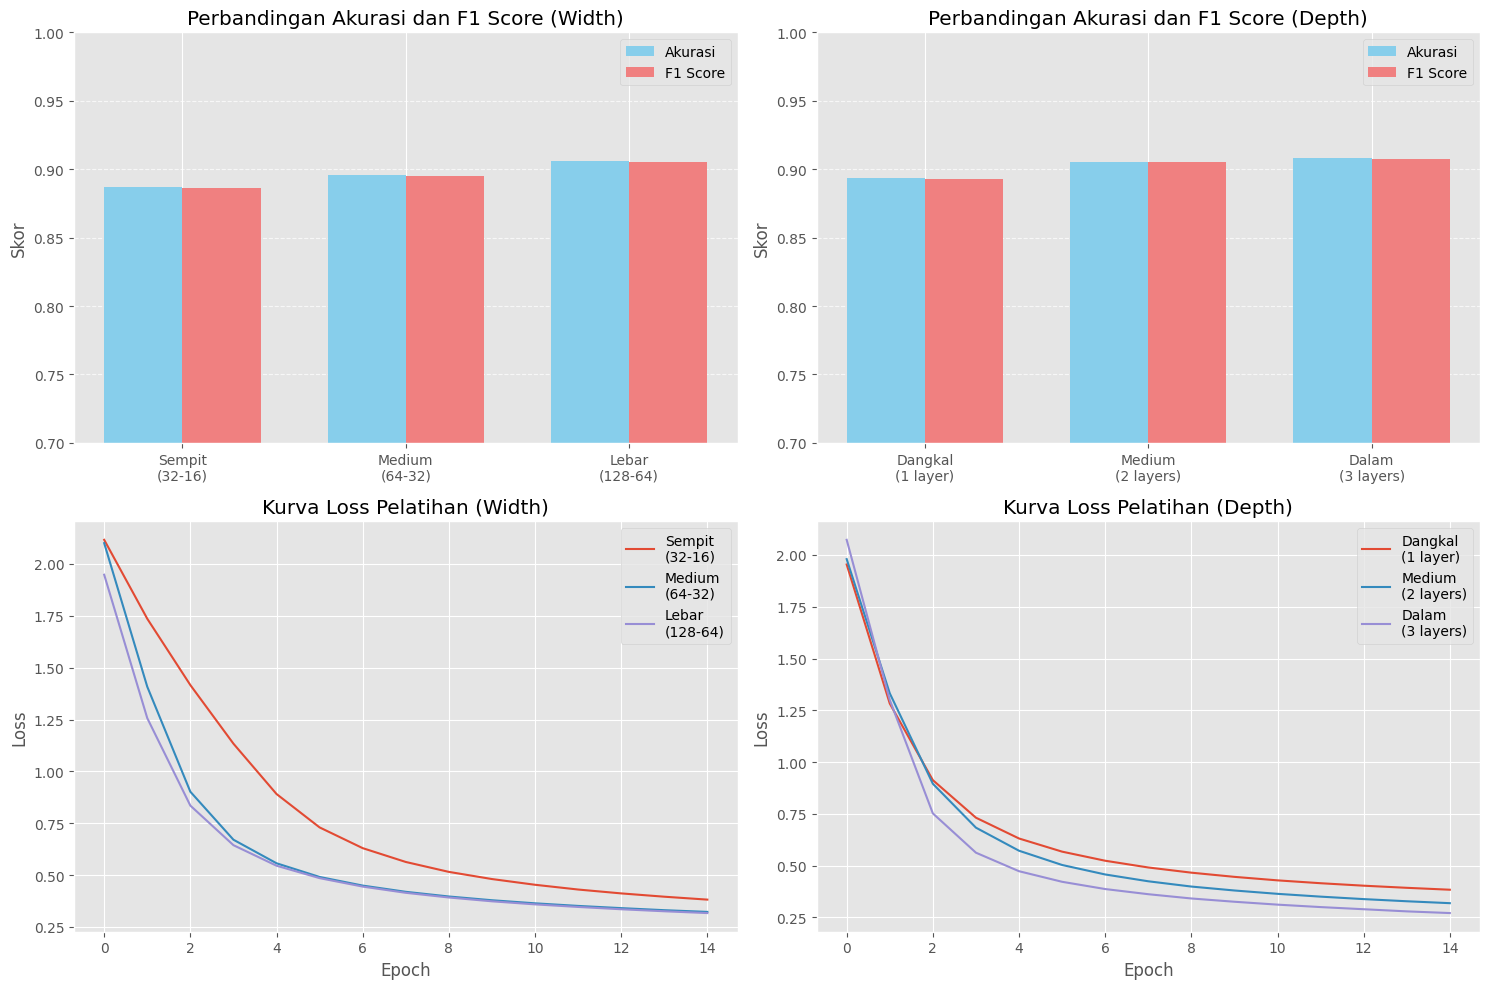

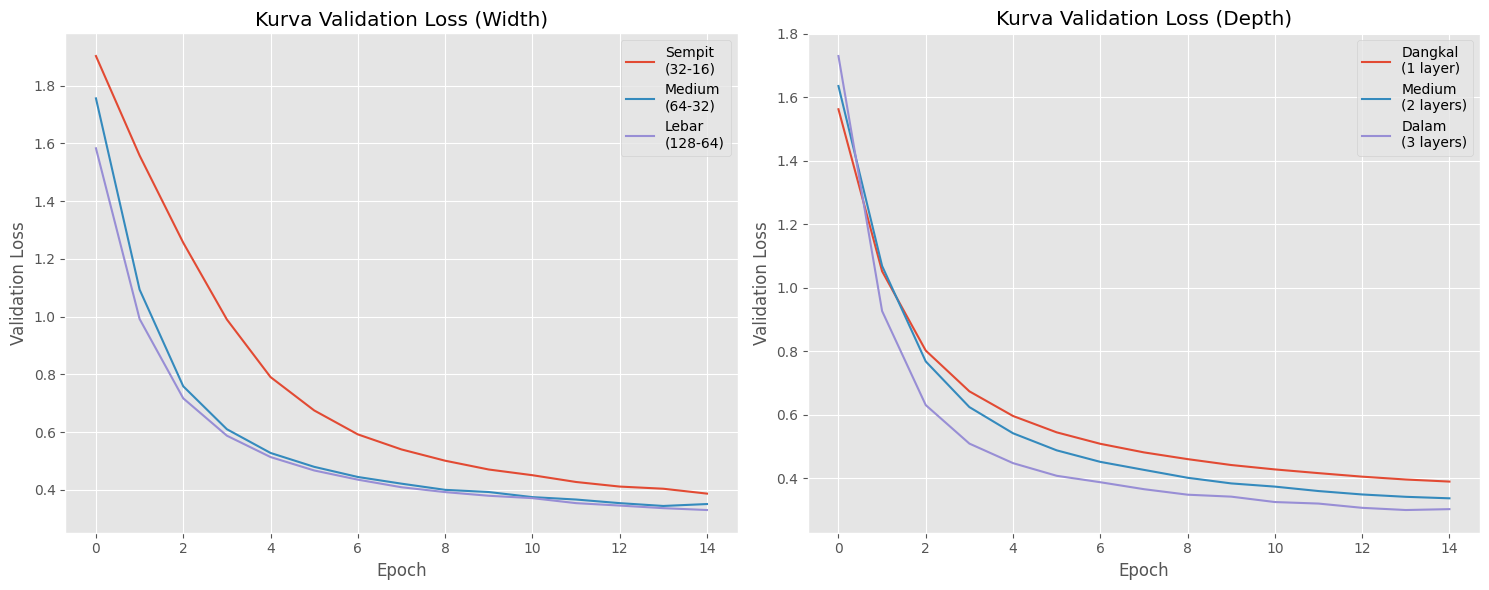

In [60]:
# VISUALISASI HASIL

# 1. Perbandingan Akurasi dan F1 Score
plt.figure(figsize=(15, 10))

# Plot hasil width
plt.subplot(2, 2, 1)
width_names = ['Sempit\n(32-16)', 'Medium\n(64-32)', 'Lebar\n(128-64)']
width_accuracies = [r['accuracy'] for r in width_results]
width_f1_scores = [r['f1_score'] for r in width_results]

x = np.arange(len(width_names))
width = 0.35
plt.bar(x - width/2, width_accuracies, width, label='Akurasi', color='skyblue')
plt.bar(x + width/2, width_f1_scores, width, label='F1 Score', color='lightcoral')
plt.title('Perbandingan Akurasi dan F1 Score (Width)')
plt.xticks(x, width_names)
plt.ylabel('Skor')
plt.ylim(0.7, 1.0)  # Sesuaikan jika diperlukan
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot hasil depth
plt.subplot(2, 2, 2)
depth_names = ['Dangkal\n(1 layer)', 'Medium\n(2 layers)', 'Dalam\n(3 layers)']
depth_accuracies = [r['accuracy'] for r in depth_results]
depth_f1_scores = [r['f1_score'] for r in depth_results]

x = np.arange(len(depth_names))
plt.bar(x - width/2, depth_accuracies, width, label='Akurasi', color='skyblue')
plt.bar(x + width/2, depth_f1_scores, width, label='F1 Score', color='lightcoral')
plt.title('Perbandingan Akurasi dan F1 Score (Depth)')
plt.xticks(x, depth_names)
plt.ylabel('Skor')
plt.ylim(0.7, 1.0)  # Sesuaikan jika diperlukan
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 2. Kurva Loss Pelatihan
plt.subplot(2, 2, 3)
for i, result in enumerate(width_results):
    plt.plot(result['history']['loss'], label=width_names[i])
plt.title('Kurva Loss Pelatihan (Width)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
for i, result in enumerate(depth_results):
    plt.plot(result['history']['loss'], label=depth_names[i])
plt.title('Kurva Loss Pelatihan (Depth)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 3. Kurva Validation Loss
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
for i, result in enumerate(width_results):
    plt.plot(result['history']['val_loss'], label=width_names[i])
plt.title('Kurva Validation Loss (Width)')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for i, result in enumerate(depth_results):
    plt.plot(result['history']['val_loss'], label=depth_names[i])
plt.title('Kurva Validation Loss (Depth)')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Pengaruh fungsi aktivasi hidden layer

In [64]:
print("==== ANALISIS PENGARUH FUNGSI AKTIVASI HIDDEN LAYER ====")

activation_functions = ['relu', 'sigmoid', 'tanh', 'leakyrelu', 'swish']
activation_results = []

# Gunakan initializer yang sama untuk semua aktivasi
initializer = 'normal'
init_params = {'std': 0.1}

# Jalankan pengujian untuk setiap fungsi aktivasi
for activation in activation_functions:
    print(f"\n[Test] Model dengan aktivasi {activation.upper()}")
    
    result = train_and_evaluate(
        X_train_subset, X_test, y_train_subset, y_test,
        hidden_layers=2,              
        width_per_layer=[64, 64],
        hidden_activation=activation,
        output_activation='softmax',
        weight_initializer=initializer,
        initializer_params=init_params,
        epochs=15,
        learning_rate=0.01,
        batch_size=128
    )
    
    # Hitung F1 score
    y_pred = result['model'].forward(X_test)
    result['f1_score'] = calculate_f1(y_test, y_pred)
    print(f"F1 Score: {result['f1_score']:.4f}")
    
    # Simpan hasil untuk visualisasi
    activation_results.append(result)

==== ANALISIS PENGARUH FUNGSI AKTIVASI HIDDEN LAYER ====

[Test] Model dengan aktivasi RELU

Training model with 2 hidden layers, width: [64, 64]
Activation: relu (hidden) | softmax (output)
Initializer: normal with params {'std': 0.1}
Neural Network Architecture Summary
Total layers: 3

Layer Details:
--------------
Input shape: (784)
  Layer 1: 784 → 64 | Activation: ReLU | Parameters: 50240
  Layer 2: 64 → 64 | Activation: ReLU | Parameters: 4160
  Layer 3: 64 → 10 | Activation: Softmax | Parameters: 650

Total trainable parameters: 55050
Epoch 1/15 - loss: 2.2153, val_loss: 2.0701
Epoch 2/15 - loss: 1.8771, val_loss: 1.6551
Epoch 3/15 - loss: 1.4105, val_loss: 1.1895
Epoch 4/15 - loss: 1.0318, val_loss: 0.9053
Epoch 5/15 - loss: 0.8172, val_loss: 0.7466
Epoch 6/15 - loss: 0.6939, val_loss: 0.6513
Epoch 7/15 - loss: 0.6151, val_loss: 0.5857
Epoch 8/15 - loss: 0.5598, val_loss: 0.5392
Epoch 9/15 - loss: 0.5191, val_loss: 0.5062
Epoch 10/15 - loss: 0.4871, val_loss: 0.4790
Epoch 11/15

### Visualisasi Hasil Analisis Pengaruh fungsi aktivasi hidden layer

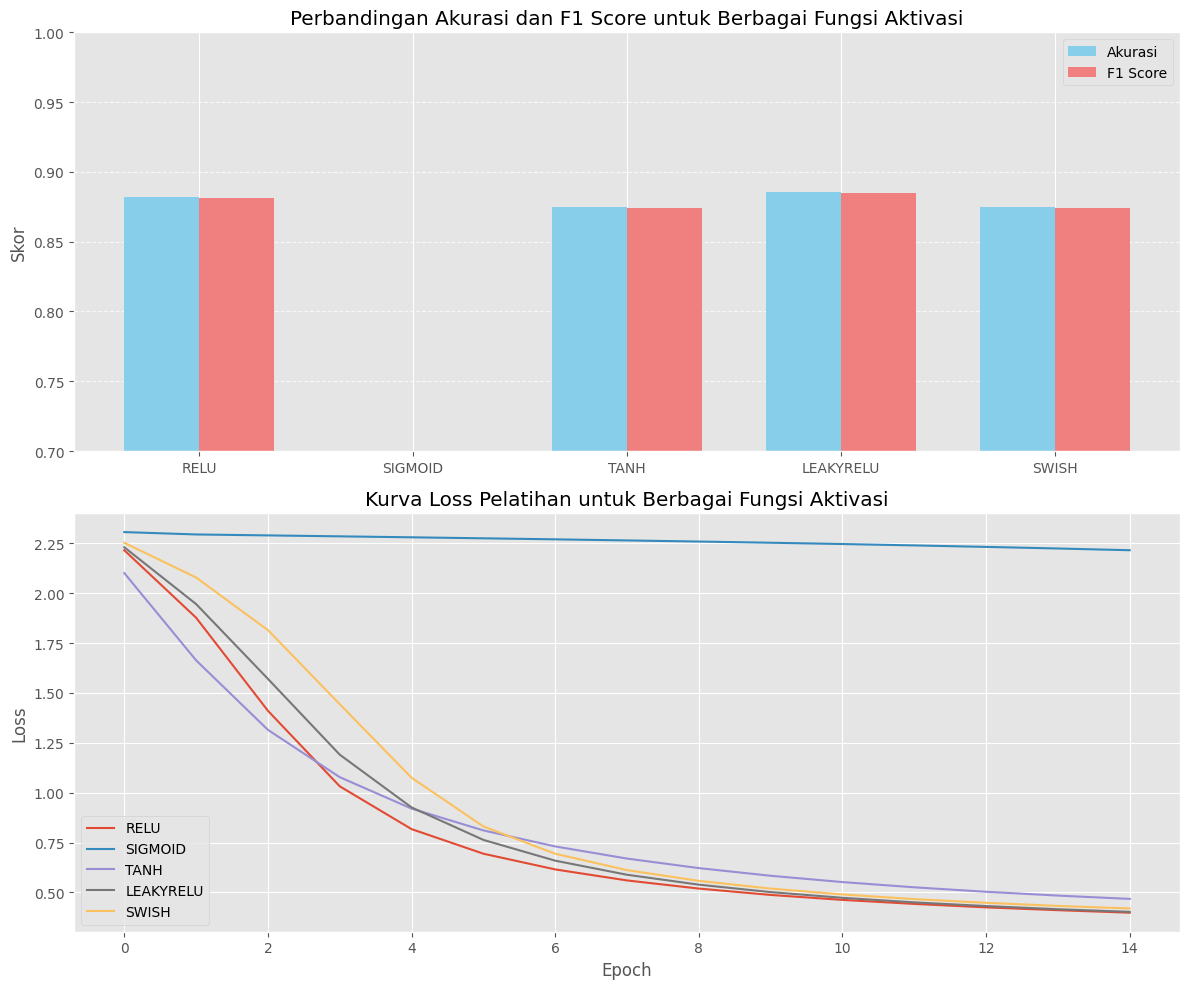

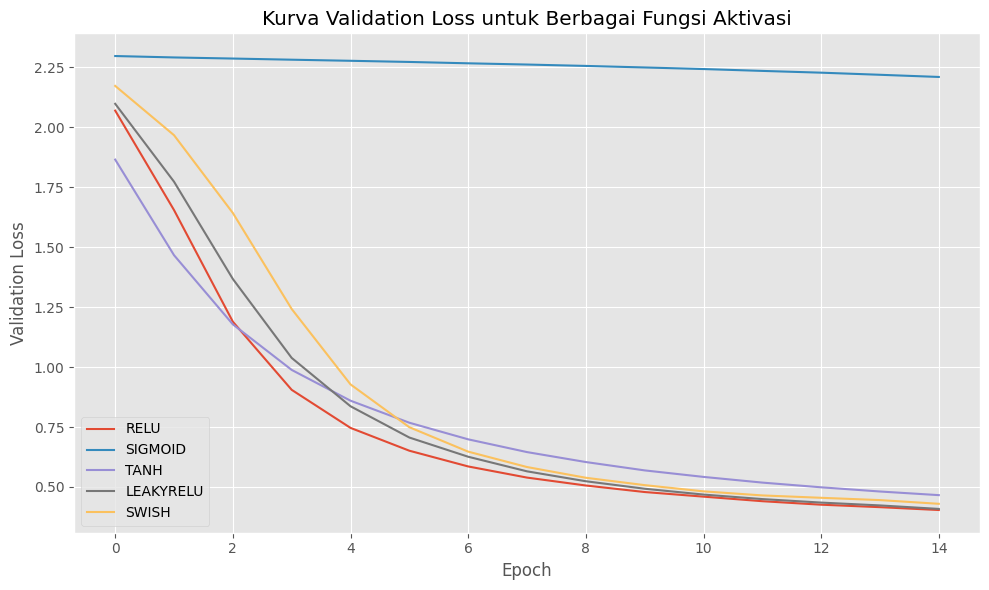

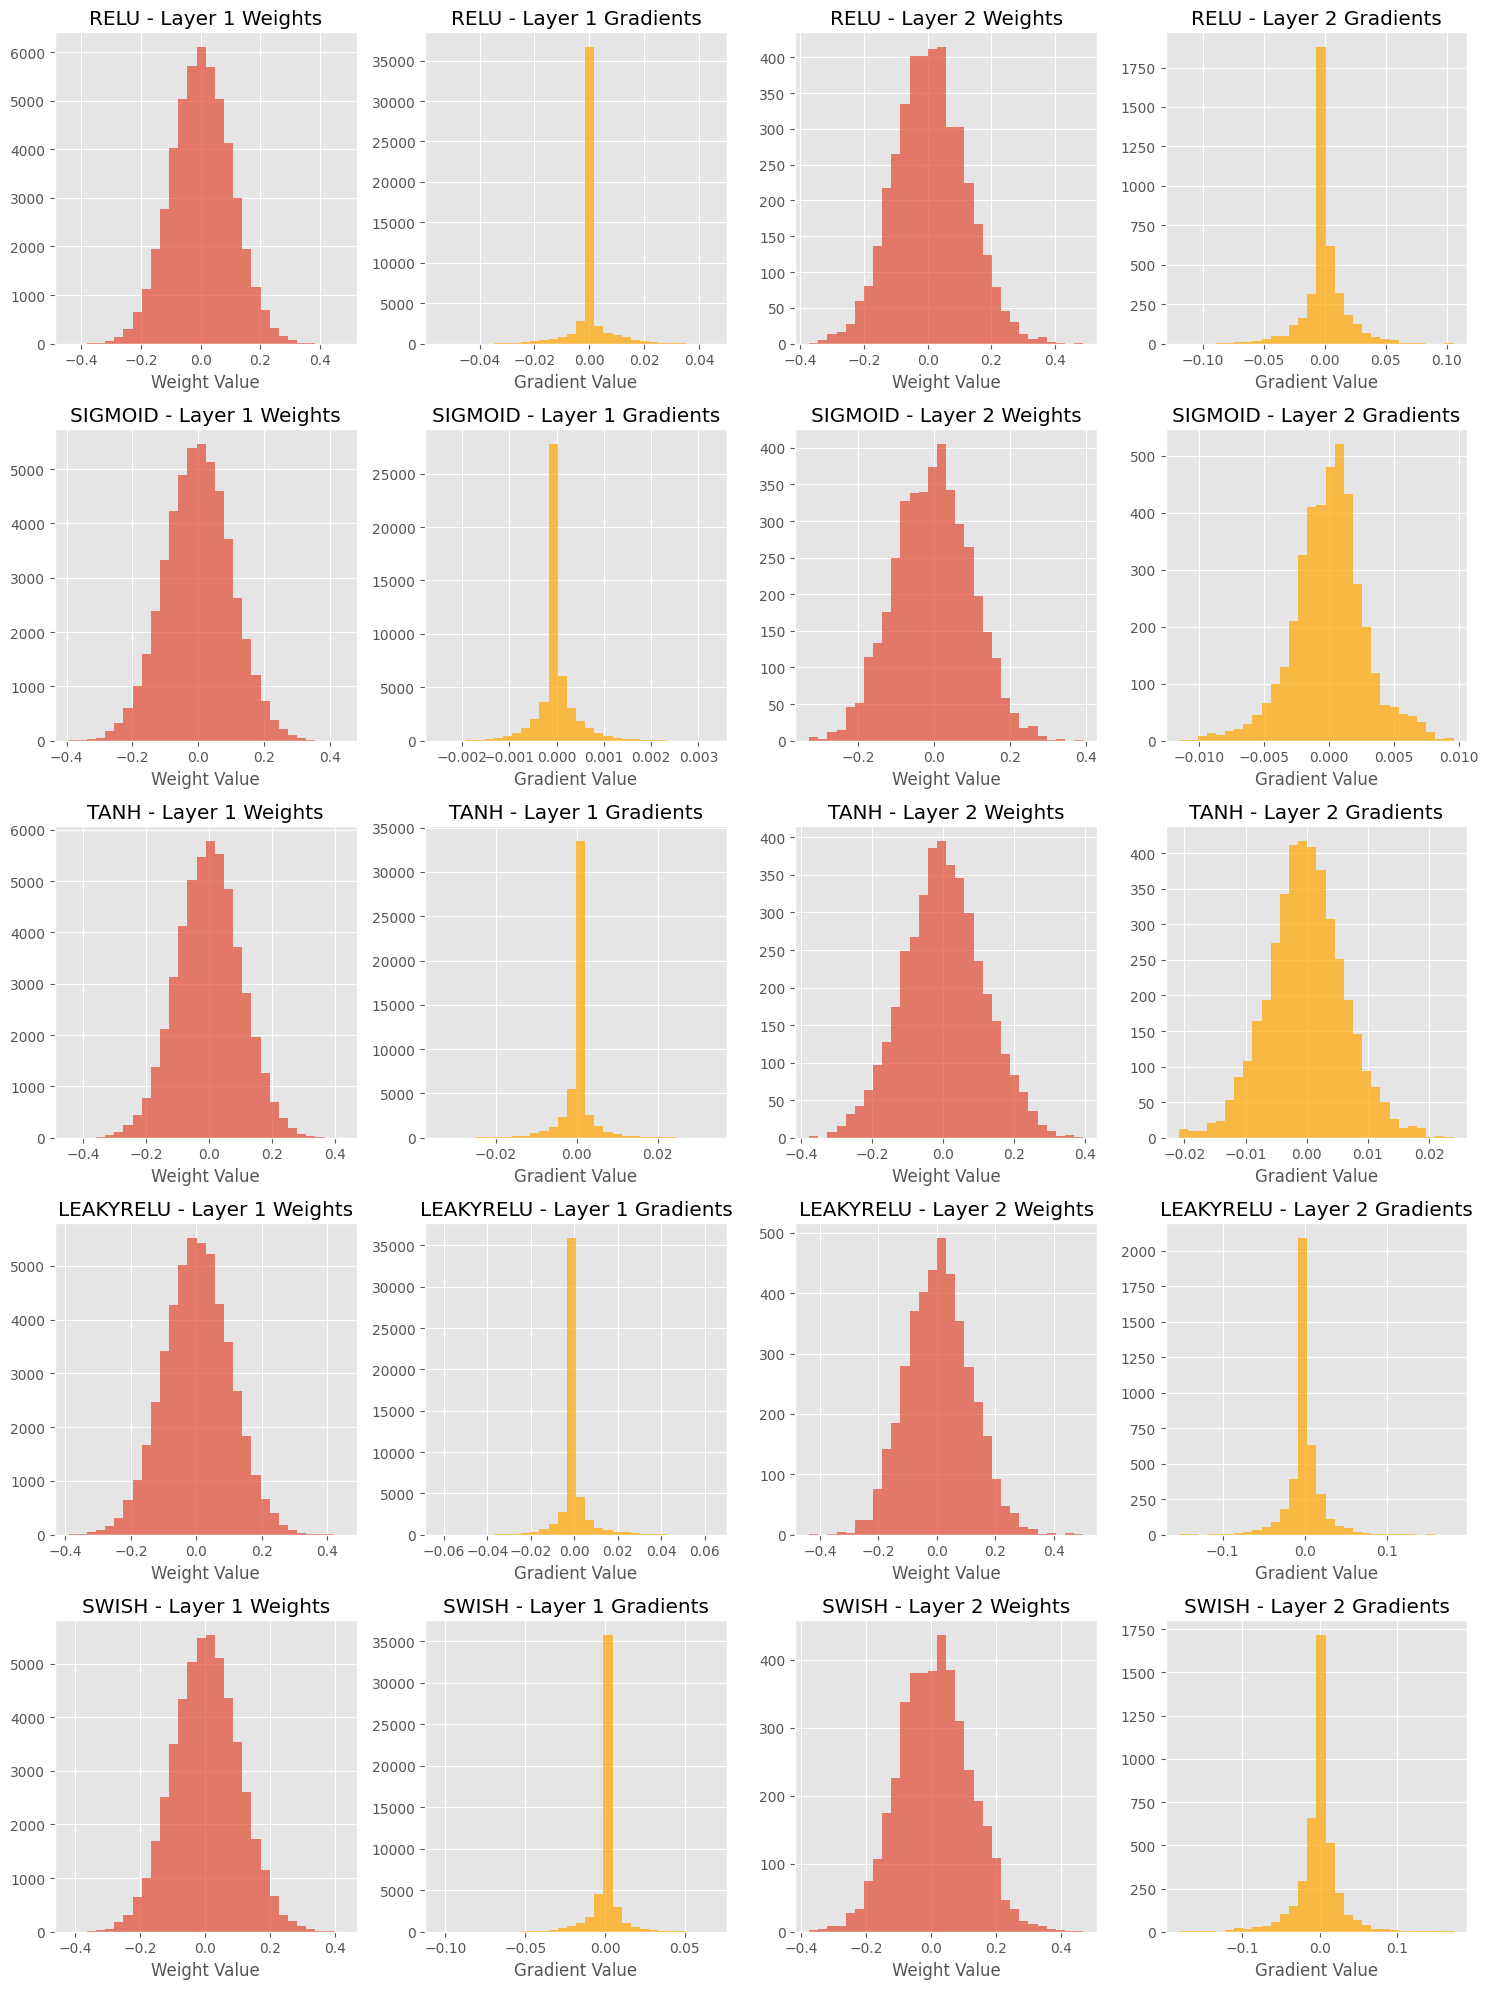

In [65]:
# VISUALISASI HASIL

# 1. Perbandingan Akurasi dan F1 Score
plt.figure(figsize=(12, 10))

# Plot perbandingan akurasi dan F1 score
plt.subplot(2, 1, 1)
activation_names = [act.upper() for act in activation_functions]
accuracies = [r['accuracy'] for r in activation_results]
f1_scores = [r['f1_score'] for r in activation_results]

x = np.arange(len(activation_names))
width = 0.35
plt.bar(x - width/2, accuracies, width, label='Akurasi', color='skyblue')
plt.bar(x + width/2, f1_scores, width, label='F1 Score', color='lightcoral')
plt.title('Perbandingan Akurasi dan F1 Score untuk Berbagai Fungsi Aktivasi')
plt.xticks(x, activation_names)
plt.ylabel('Skor')
plt.ylim(0.7, 1.0)  # Sesuaikan jika diperlukan
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 2. Kurva Loss Pelatihan
plt.subplot(2, 1, 2)
for i, result in enumerate(activation_results):
    plt.plot(result['history']['loss'], label=activation_names[i])
plt.title('Kurva Loss Pelatihan untuk Berbagai Fungsi Aktivasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 3. Kurva Validation Loss
plt.figure(figsize=(10, 6))
for i, result in enumerate(activation_results):
    plt.plot(result['history']['val_loss'], label=activation_names[i])
plt.title('Kurva Validation Loss untuk Berbagai Fungsi Aktivasi')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Visualisasi Distribusi Bobot dan Gradien
plt.figure(figsize=(15, 20))
for i, result in enumerate(activation_results):
    model = result['model']
    activation = activation_functions[i].upper()
    
    # Untuk setiap layer (kecuali output), tampilkan distribusi bobot dan gradien
    for l, layer in enumerate(model.layers[:2]):  # Hanya hidden layers
        # Distribusi bobot
        plt.subplot(5, 4, i*4 + l*2 + 1)
        weights = layer.W.flatten()
        plt.hist(weights, bins=30, alpha=0.7)
        plt.title(f'{activation} - Layer {l+1} Weights')
        plt.xlabel('Weight Value')
        
        # Distribusi gradien
        plt.subplot(5, 4, i*4 + l*2 + 2)
        if hasattr(layer, 'dW') and layer.dW is not None:
            gradients = layer.dW.flatten()
            plt.hist(gradients, bins=30, alpha=0.7, color='orange')
            plt.title(f'{activation} - Layer {l+1} Gradients')
            plt.xlabel('Gradient Value')
        else:
            plt.text(0.5, 0.5, "No gradient data available", 
                    ha='center', va='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

### Pengaruh learning rate

In [66]:
print("==== ANALISIS PENGARUH LEARNING RATE ====")

# Definisikan learning rate yang akan diuji
learning_rates = [0.001, 0.01, 0.1]
lr_results = []

# Jalankan pengujian untuk setiap learning rate
for lr in learning_rates:
    print(f"\n[Test] Model dengan learning rate {lr}")
    
    result = train_and_evaluate(
        X_train_subset, X_test, y_train_subset, y_test,
        hidden_layers=2,              
        width_per_layer=[64, 64],
        hidden_activation='relu',
        output_activation='softmax',
        weight_initializer='he',
        epochs=15,
        learning_rate=lr,  # Variasi learning rate
        batch_size=128
    )
    
    # Hitung F1 score
    y_pred = result['model'].forward(X_test)
    result['f1_score'] = calculate_f1(y_test, y_pred)
    print(f"F1 Score: {result['f1_score']:.4f}")
    
    # Simpan hasil untuk visualisasi
    lr_results.append(result)

==== ANALISIS PENGARUH LEARNING RATE ====

[Test] Model dengan learning rate 0.001

Training model with 2 hidden layers, width: [64, 64]
Activation: relu (hidden) | softmax (output)
Initializer: he with params {'std': 0.1}
Neural Network Architecture Summary
Total layers: 3

Layer Details:
--------------
Input shape: (784)
  Layer 1: 784 → 64 | Activation: ReLU | Parameters: 50240
  Layer 2: 64 → 64 | Activation: ReLU | Parameters: 4160
  Layer 3: 64 → 10 | Activation: Softmax | Parameters: 650

Total trainable parameters: 55050
Epoch 1/15 - loss: 2.3410, val_loss: 2.2818
Epoch 2/15 - loss: 2.2333, val_loss: 2.1871
Epoch 3/15 - loss: 2.1431, val_loss: 2.1007
Epoch 4/15 - loss: 2.0572, val_loss: 2.0154
Epoch 5/15 - loss: 1.9714, val_loss: 1.9285
Epoch 6/15 - loss: 1.8838, val_loss: 1.8399
Epoch 7/15 - loss: 1.7947, val_loss: 1.7503
Epoch 8/15 - loss: 1.7050, val_loss: 1.6615
Epoch 9/15 - loss: 1.6169, val_loss: 1.5751
Epoch 10/15 - loss: 1.5320, val_loss: 1.4930
Epoch 11/15 - loss: 1.45

### Visualisasi Hasil Analisis Pengaruh learning rate

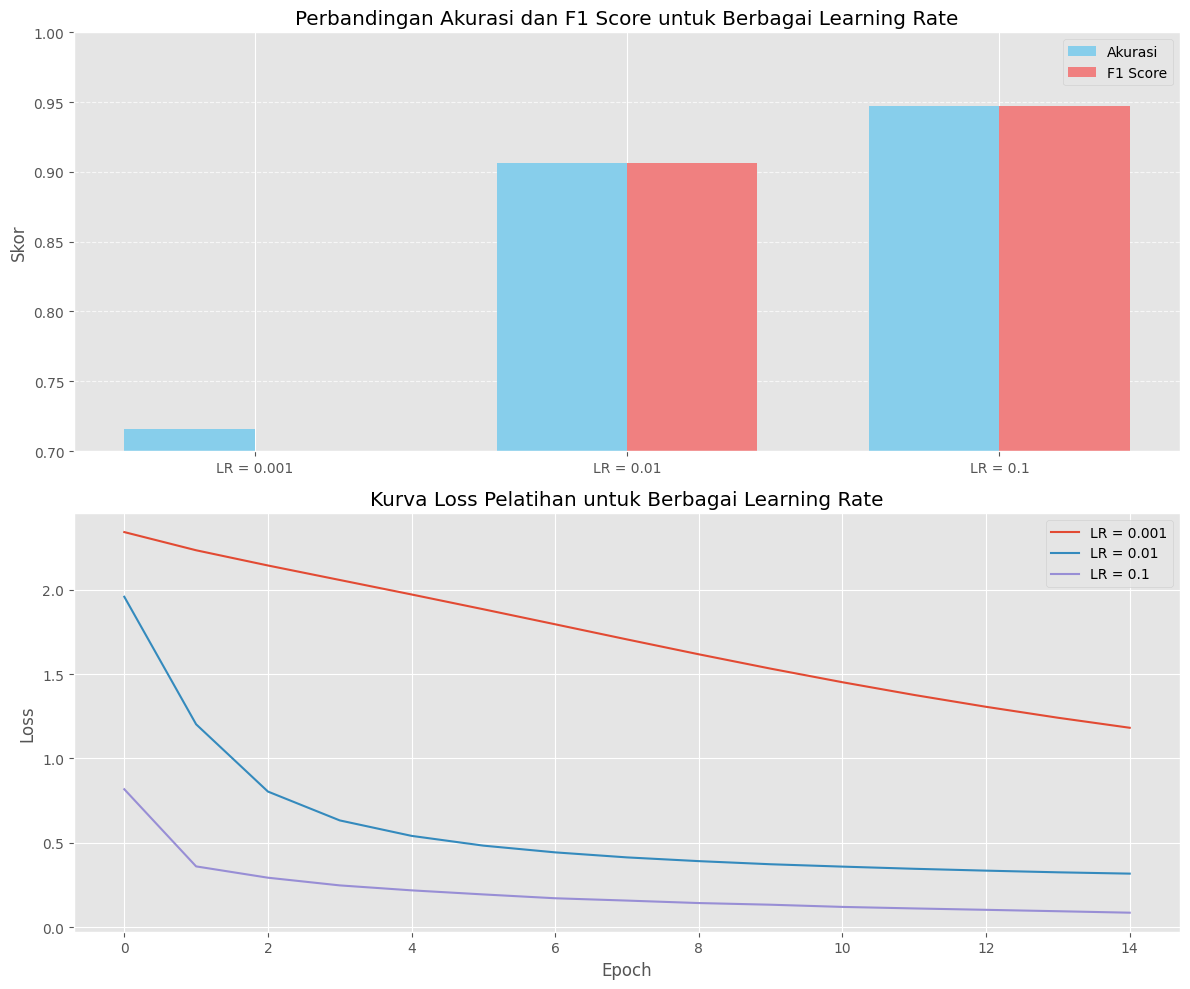

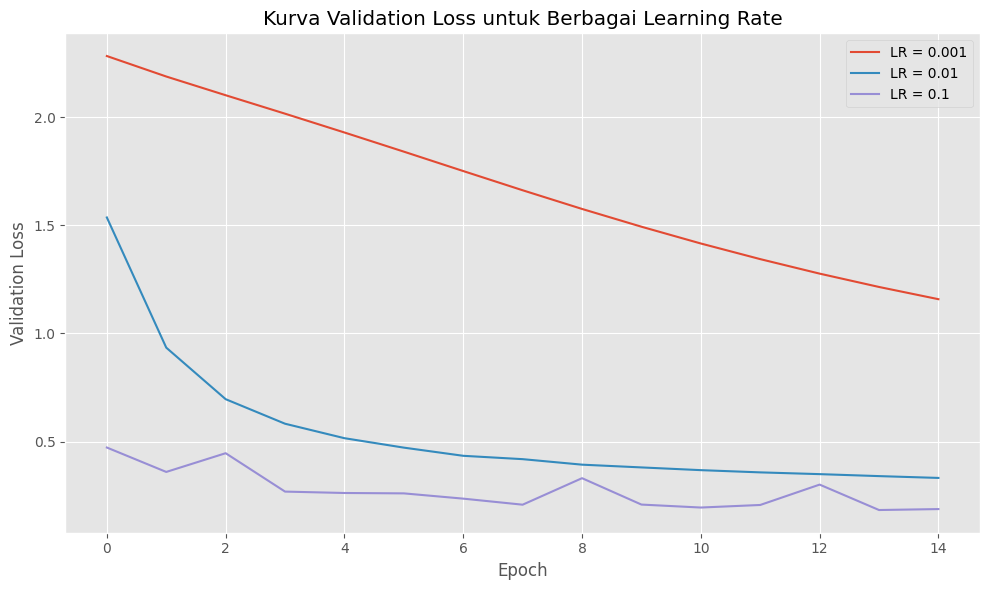

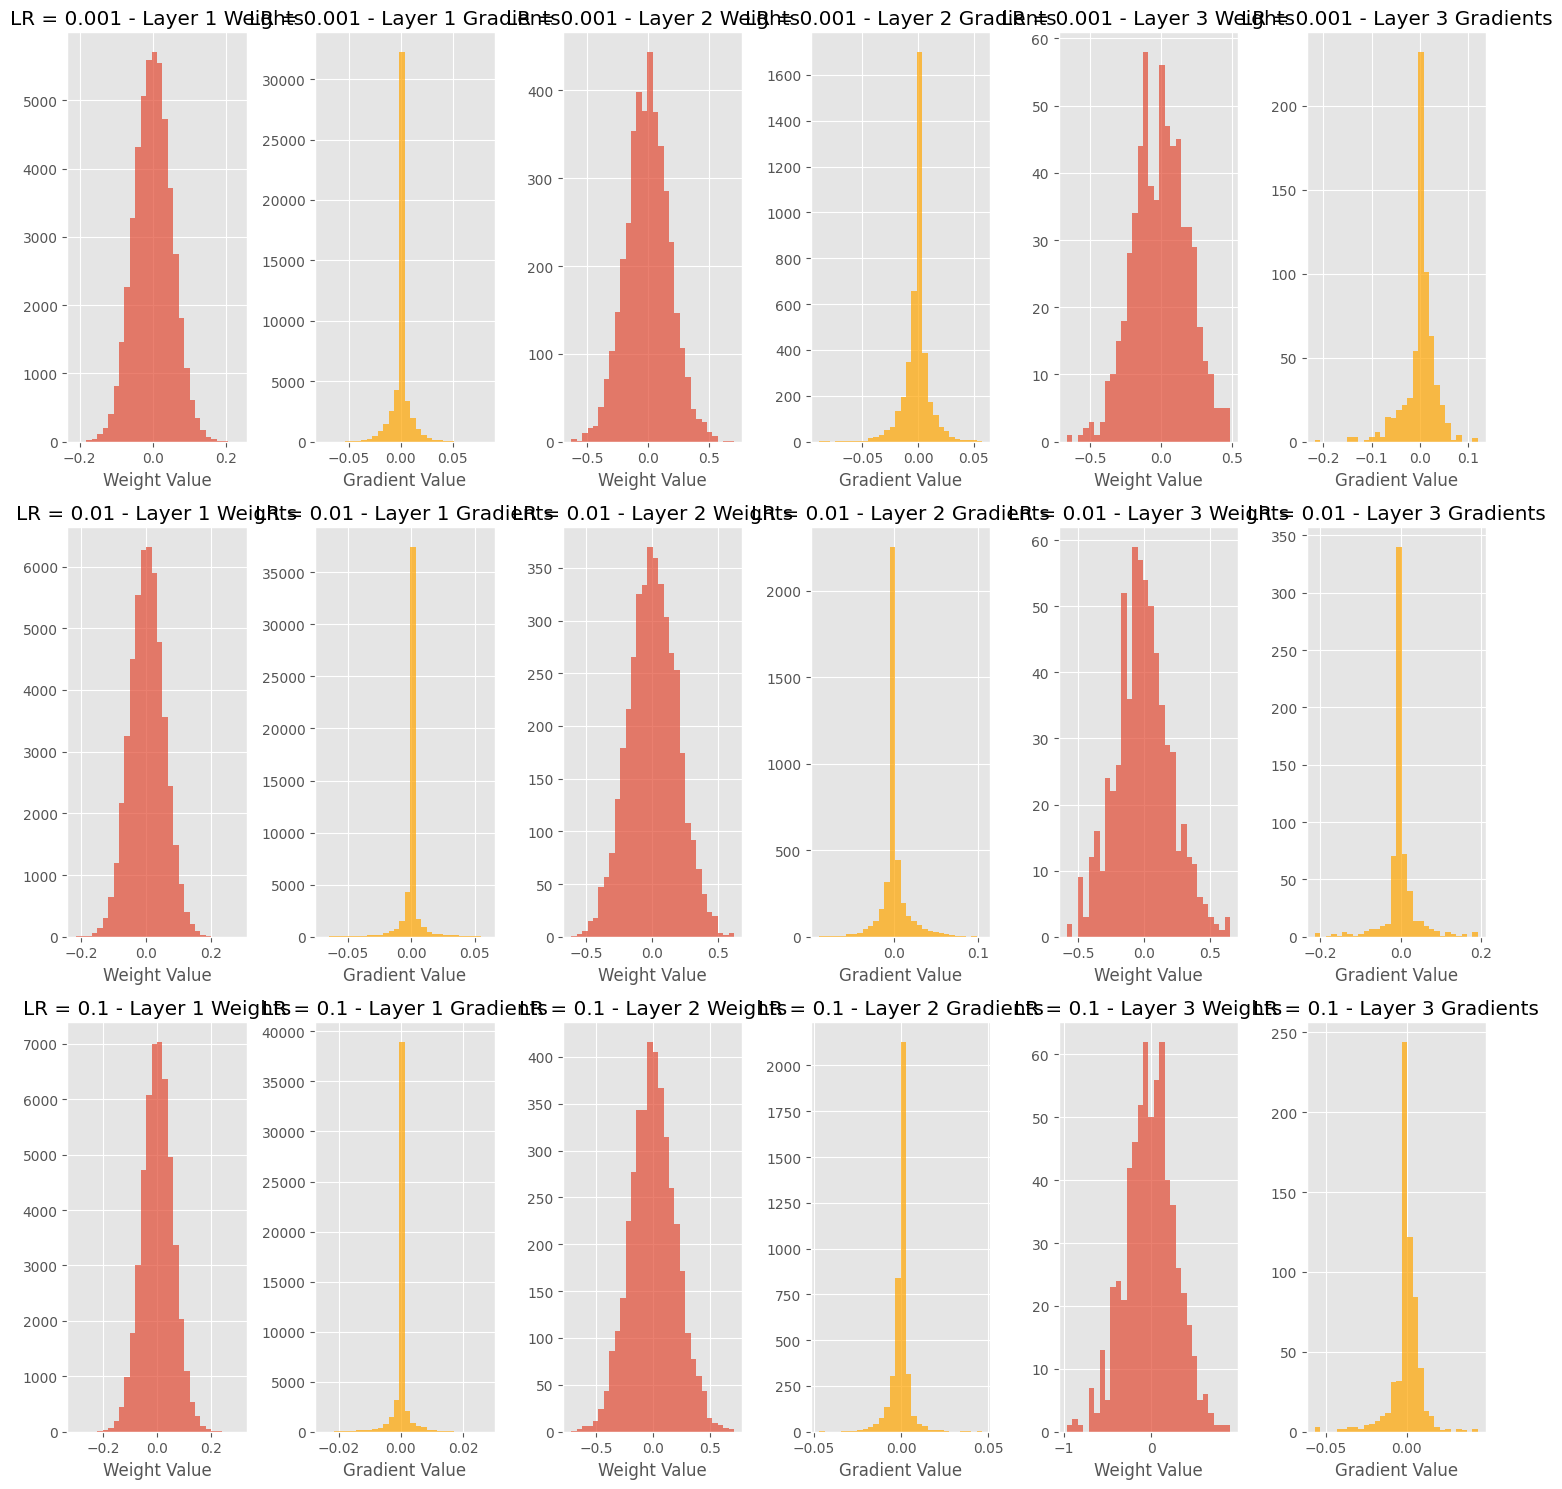

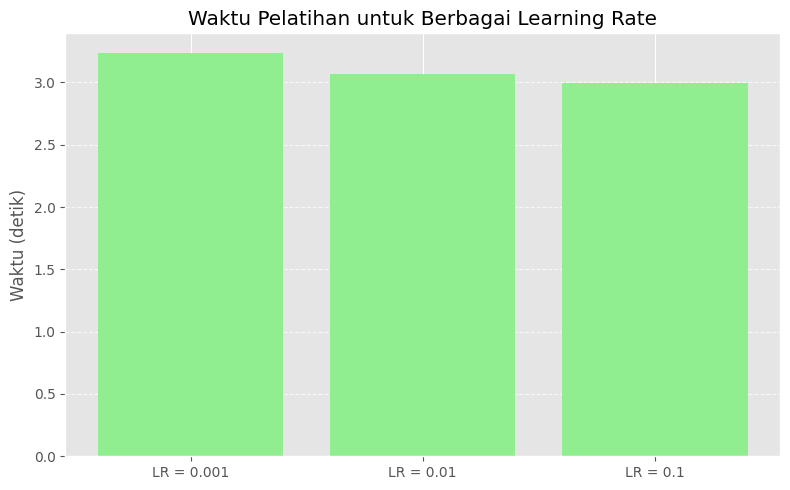

In [67]:
# VISUALISASI HASIL

# 1. Perbandingan Akurasi dan F1 Score
plt.figure(figsize=(12, 10))

# Plot perbandingan akurasi dan F1 score
plt.subplot(2, 1, 1)
lr_labels = [f'LR = {lr}' for lr in learning_rates]
accuracies = [r['accuracy'] for r in lr_results]
f1_scores = [r['f1_score'] for r in lr_results]

x = np.arange(len(lr_labels))
width = 0.35
plt.bar(x - width/2, accuracies, width, label='Akurasi', color='skyblue')
plt.bar(x + width/2, f1_scores, width, label='F1 Score', color='lightcoral')
plt.title('Perbandingan Akurasi dan F1 Score untuk Berbagai Learning Rate')
plt.xticks(x, lr_labels)
plt.ylabel('Skor')
plt.ylim(0.7, 1.0)  # Sesuaikan jika diperlukan
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 2. Kurva Loss Pelatihan
plt.subplot(2, 1, 2)
for i, result in enumerate(lr_results):
    plt.plot(result['history']['loss'], label=lr_labels[i])
plt.title('Kurva Loss Pelatihan untuk Berbagai Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 3. Kurva Validation Loss
plt.figure(figsize=(10, 6))
for i, result in enumerate(lr_results):
    plt.plot(result['history']['val_loss'], label=lr_labels[i])
plt.title('Kurva Validation Loss untuk Berbagai Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Visualisasi Distribusi Bobot dan Gradien
plt.figure(figsize=(15, 15))
for i, result in enumerate(lr_results):
    model = result['model']
    lr_label = lr_labels[i]
    
    # Untuk setiap layer, tampilkan distribusi bobot dan gradien
    for l, layer in enumerate(model.layers):
        # Distribusi bobot
        plt.subplot(3, 6, i*6 + l*2 + 1)
        weights = layer.W.flatten()
        plt.hist(weights, bins=30, alpha=0.7)
        plt.title(f'{lr_label} - Layer {l+1} Weights')
        plt.xlabel('Weight Value')
        
        # Distribusi gradien
        plt.subplot(3, 6, i*6 + l*2 + 2)
        if hasattr(layer, 'dW') and layer.dW is not None:
            gradients = layer.dW.flatten()
            plt.hist(gradients, bins=30, alpha=0.7, color='orange')
            plt.title(f'{lr_label} - Layer {l+1} Gradients')
            plt.xlabel('Gradient Value')
        else:
            plt.text(0.5, 0.5, "No gradient data available", 
                    ha='center', va='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

# 5. Perbandingan Waktu Pelatihan
plt.figure(figsize=(8, 5))
training_times = [r['training_time'] for r in lr_results]
plt.bar(lr_labels, training_times, color='lightgreen')
plt.title('Waktu Pelatihan untuk Berbagai Learning Rate')
plt.ylabel('Waktu (detik)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Pengaruh inisialisasi bobot

In [43]:
print("==== ANALISIS PENGARUH INISIALISASI BOBOT ====")

# Definisikan metode inisialisasi yang akan diuji
initializers = [
    ('zeros', {}),
    ('uniform', {'low': -0.05, 'high': 0.05}),
    ('normal', {'mean': 0, 'std': 0.05}),
    ('xavier', {}),
    ('he', {})
]
init_results = []

# Jalankan pengujian untuk setiap metode inisialisasi
for init_name, init_params in initializers:
    print(f"\n[Test] Model dengan inisialisasi {init_name.upper()}")
    
    result = train_and_evaluate(
        X_train_subset, X_test, y_train_subset, y_test,
        hidden_layers=2,              
        width_per_layer=[64, 64],
        hidden_activation='relu',
        output_activation='softmax',
        weight_initializer=init_name,  # Variasi inisialisasi
        initializer_params=init_params,
        epochs=15,
        learning_rate=0.01,
        batch_size=128
    )
    
    # Hitung F1 score
    y_pred = result['model'].forward(X_test)
    result['f1_score'] = calculate_f1(y_test, y_pred)
    print(f"F1 Score: {result['f1_score']:.4f}")
    
    # Simpan hasil untuk visualisasi
    init_results.append(result)

==== ANALISIS PENGARUH INISIALISASI BOBOT ====

[Test] Model dengan inisialisasi ZEROS

Training model with 2 hidden layers, width: [64, 64]
Activation: relu (hidden) | softmax (output)
Initializer: zeros with params {}
Neural Network Architecture Summary
Total layers: 3

Layer Details:
--------------
Input shape: (784)
  Layer 1: 784 → 64 | Activation: ReLU | Parameters: 50240
  Layer 2: 64 → 64 | Activation: ReLU | Parameters: 4160
  Layer 3: 64 → 10 | Activation: Softmax | Parameters: 650

Total trainable parameters: 55050
Epoch 1/15 - loss: 2.3024, val_loss: 2.3023
Epoch 2/15 - loss: 2.3021, val_loss: 2.3020
Epoch 3/15 - loss: 2.3018, val_loss: 2.3019
Epoch 4/15 - loss: 2.3016, val_loss: 2.3017
Epoch 5/15 - loss: 2.3014, val_loss: 2.3016
Epoch 6/15 - loss: 2.3013, val_loss: 2.3015
Epoch 7/15 - loss: 2.3012, val_loss: 2.3015
Epoch 8/15 - loss: 2.3011, val_loss: 2.3014
Epoch 9/15 - loss: 2.3010, val_loss: 2.3014
Epoch 10/15 - loss: 2.3010, val_loss: 2.3014
Epoch 11/15 - loss: 2.3010,

### Visualisasi Analisis Pengaruh inisialisasi bobot

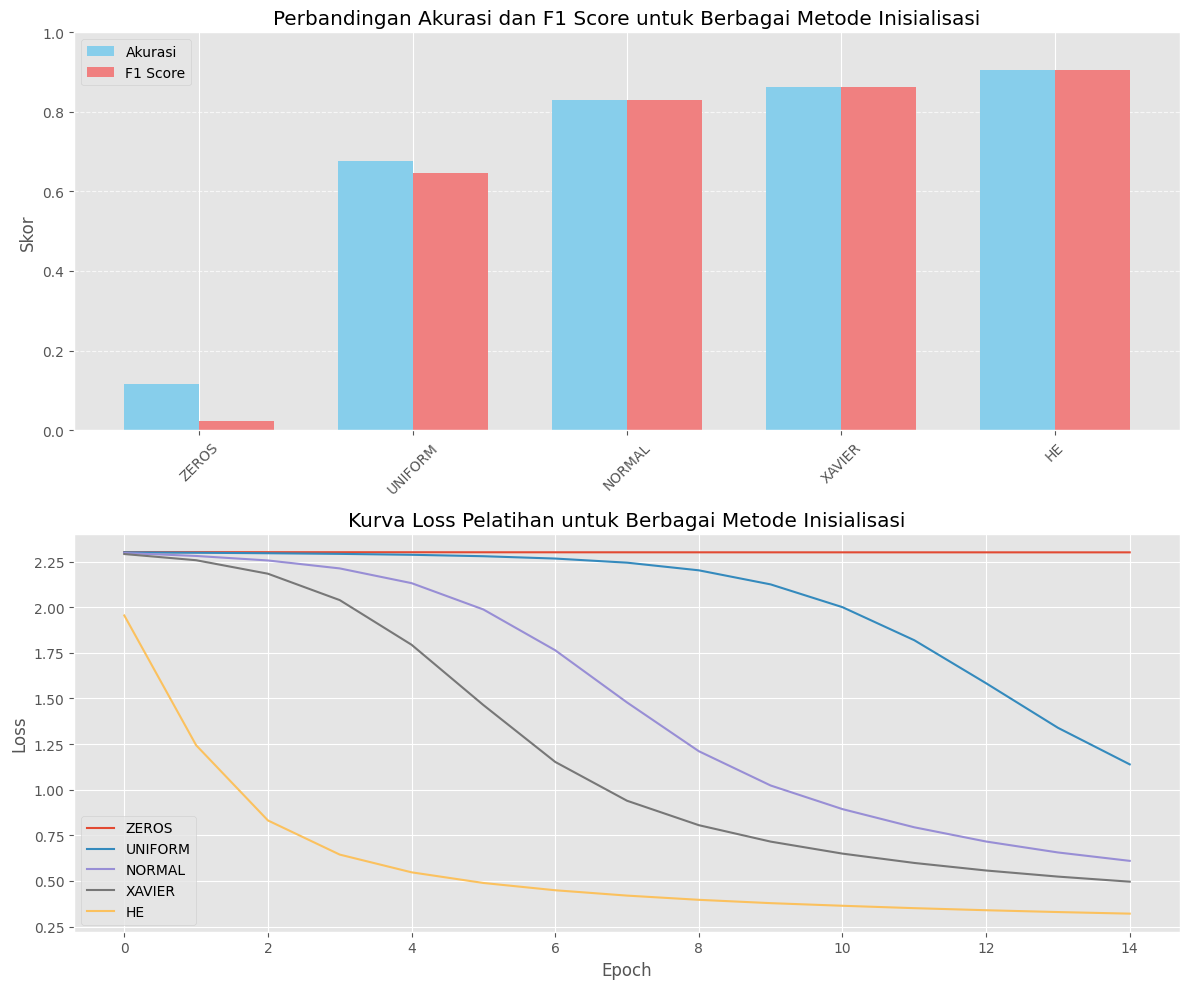

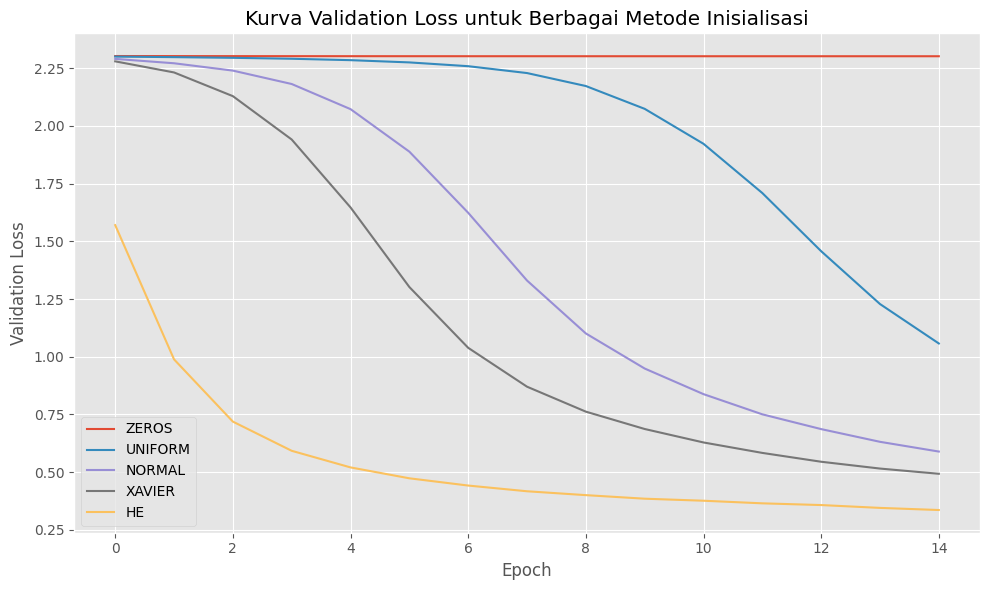

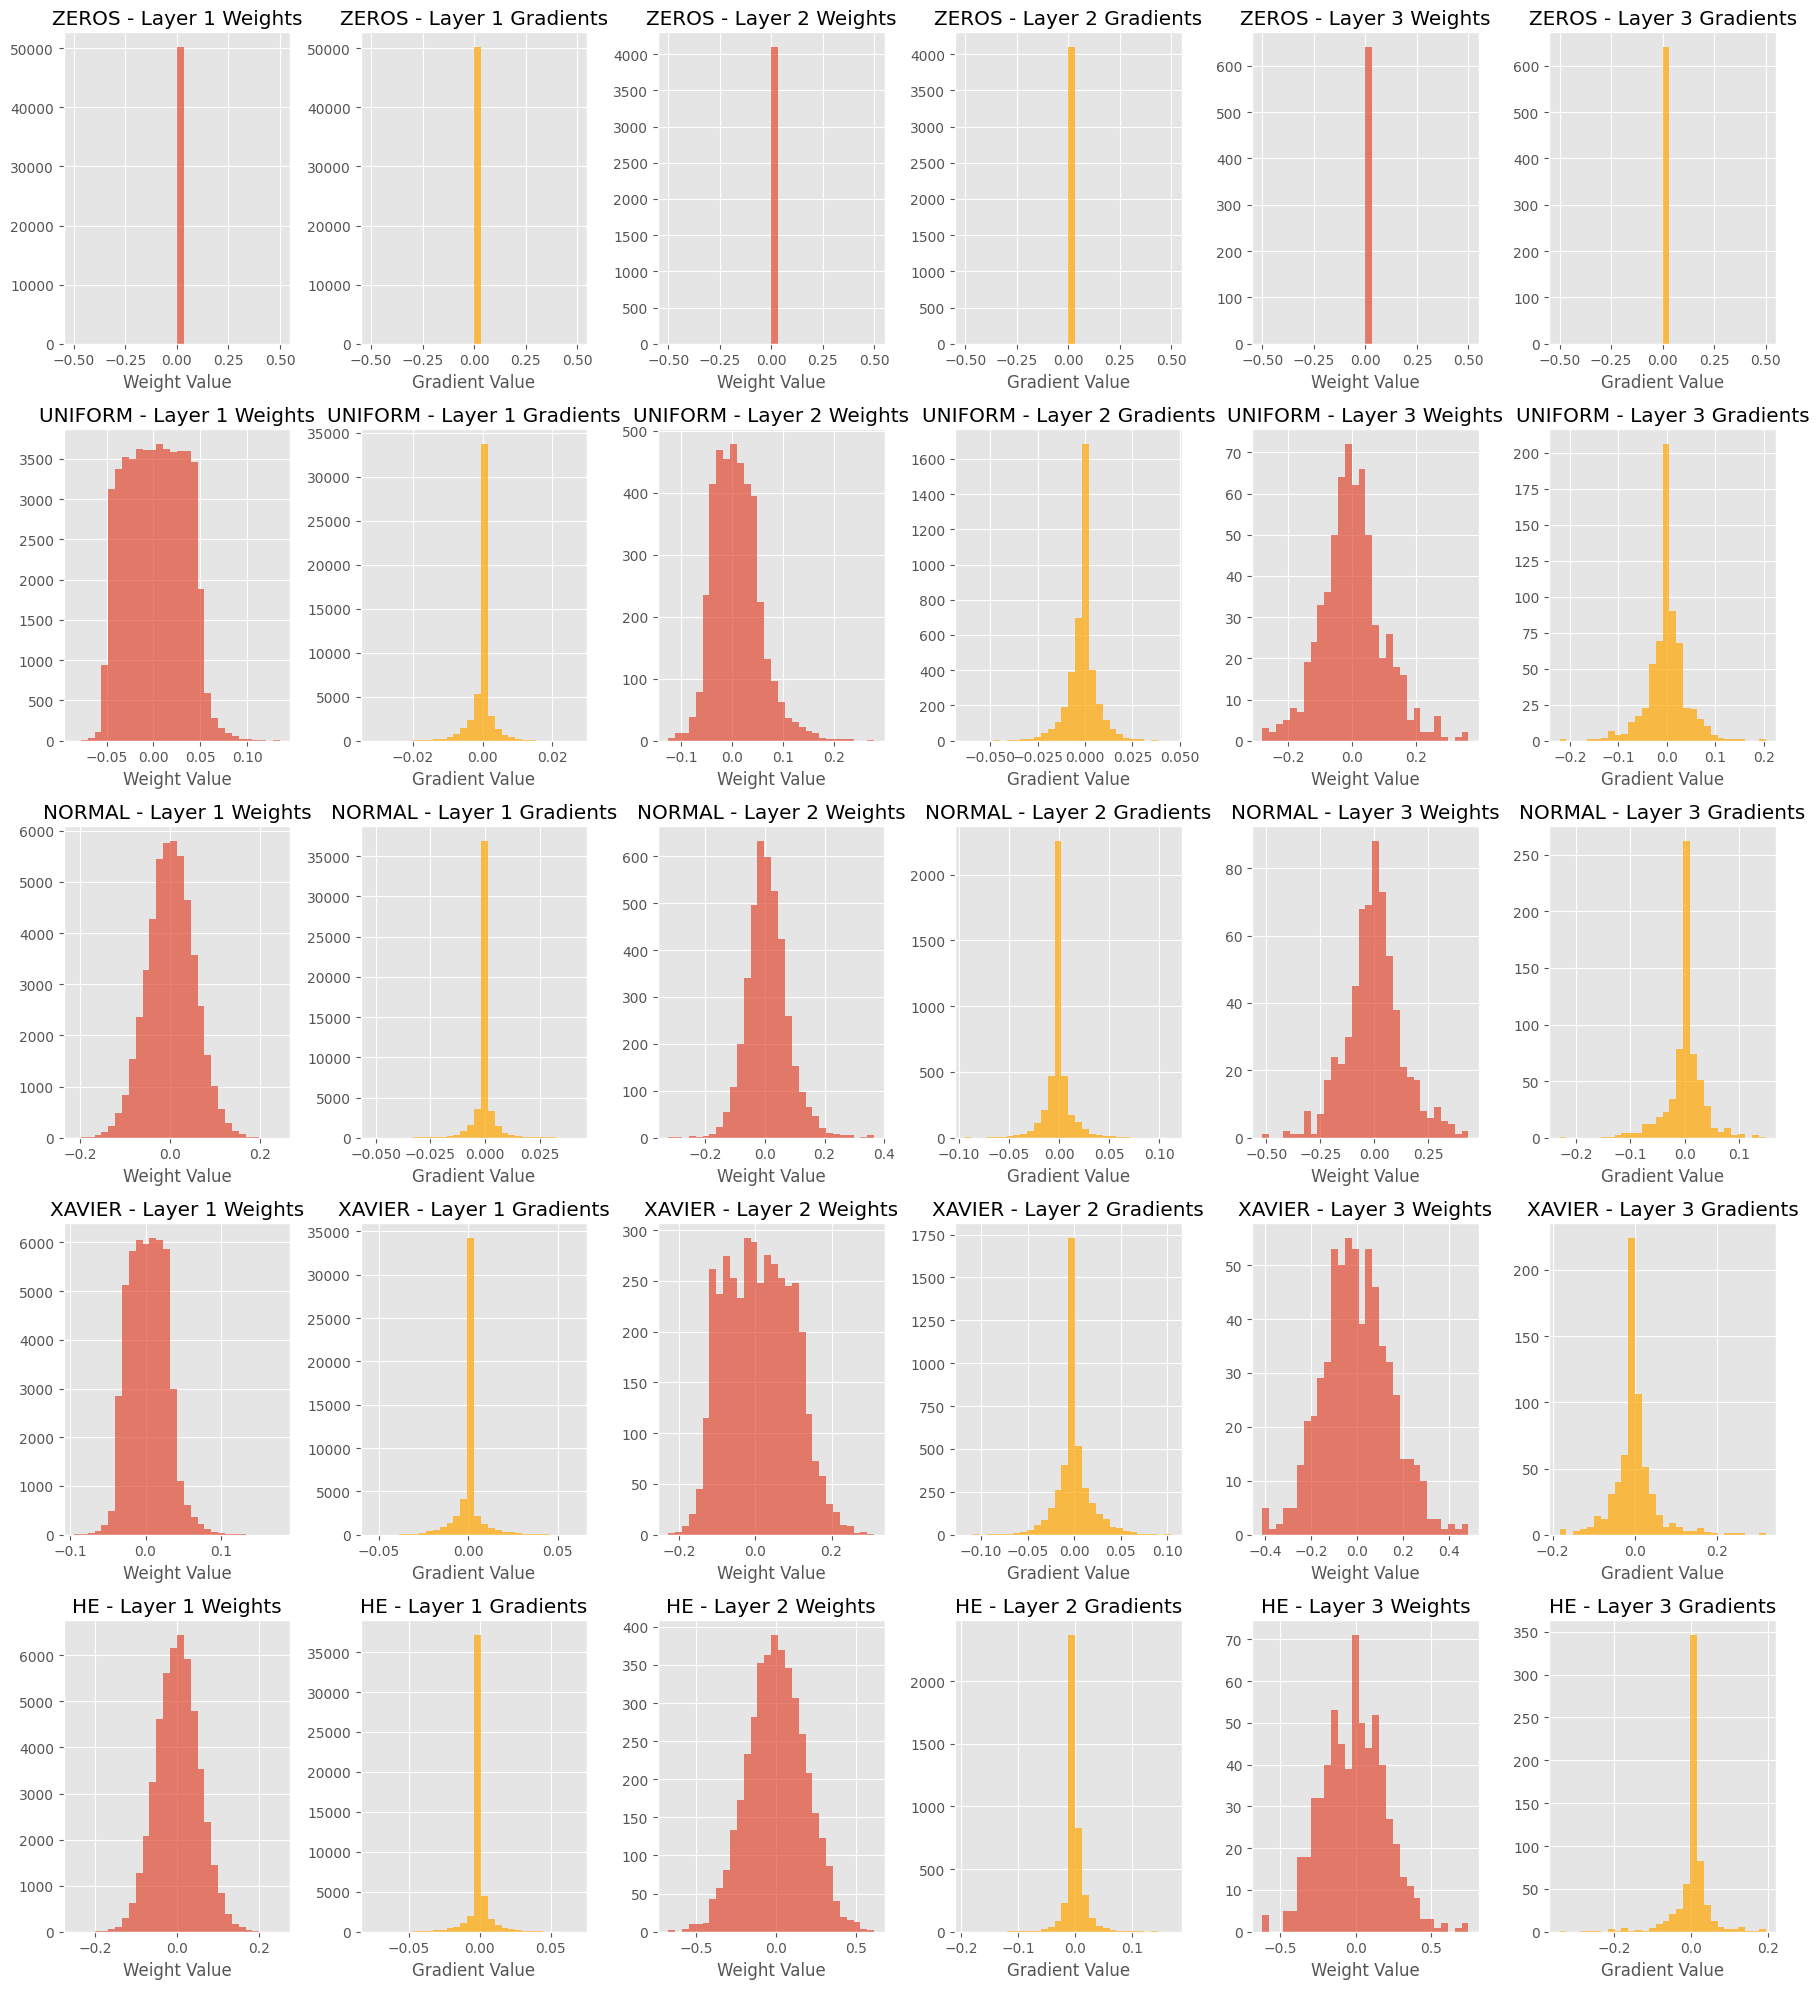

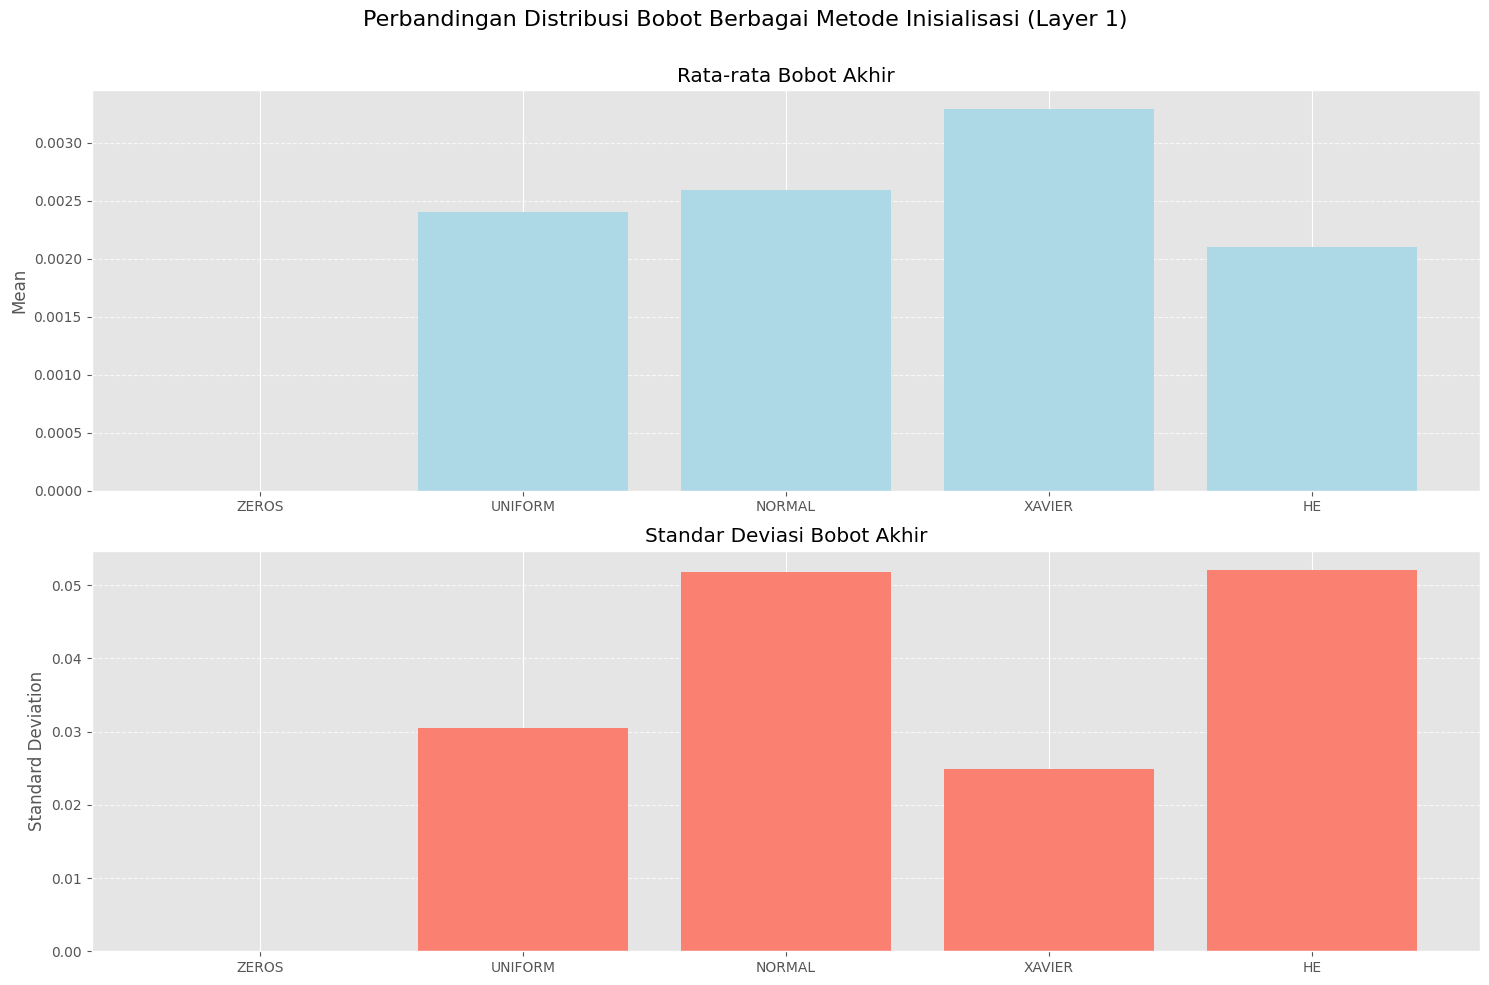

In [44]:
# VISUALISASI HASIL

# 1. Perbandingan Akurasi dan F1 Score
plt.figure(figsize=(12, 10))

# Plot perbandingan akurasi dan F1 score
plt.subplot(2, 1, 1)
init_labels = [name.upper() for name, _ in initializers]
accuracies = [r['accuracy'] for r in init_results]
f1_scores = [r['f1_score'] for r in init_results]

x = np.arange(len(init_labels))
width = 0.35
plt.bar(x - width/2, accuracies, width, label='Akurasi', color='skyblue')
plt.bar(x + width/2, f1_scores, width, label='F1 Score', color='lightcoral')
plt.title('Perbandingan Akurasi dan F1 Score untuk Berbagai Metode Inisialisasi')
plt.xticks(x, init_labels, rotation=45)
plt.ylabel('Skor')
plt.ylim(0, 1.0)  # Mulai dari 0 untuk menunjukkan perbedaan yang jelas
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 2. Kurva Loss Pelatihan
plt.subplot(2, 1, 2)
for i, result in enumerate(init_results):
    plt.plot(result['history']['loss'], label=init_labels[i])
plt.title('Kurva Loss Pelatihan untuk Berbagai Metode Inisialisasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 3. Kurva Validation Loss
plt.figure(figsize=(10, 6))
for i, result in enumerate(init_results):
    plt.plot(result['history']['val_loss'], label=init_labels[i])
plt.title('Kurva Validation Loss untuk Berbagai Metode Inisialisasi')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Visualisasi Distribusi Bobot dan Gradien
plt.figure(figsize=(18, 20))
for i, result in enumerate(init_results):
    model = result['model']
    init_label = init_labels[i]
    
    # Untuk setiap layer, tampilkan distribusi bobot dan gradien
    for l, layer in enumerate(model.layers):
        # Distribusi bobot
        plt.subplot(5, 6, i*6 + l*2 + 1)
        weights = layer.W.flatten()
        plt.hist(weights, bins=30, alpha=0.7)
        plt.title(f'{init_label} - Layer {l+1} Weights')
        plt.xlabel('Weight Value')
        
        # Distribusi gradien
        plt.subplot(5, 6, i*6 + l*2 + 2)
        if hasattr(layer, 'dW') and layer.dW is not None:
            gradients = layer.dW.flatten()
            plt.hist(gradients, bins=30, alpha=0.7, color='orange')
            plt.title(f'{init_label} - Layer {l+1} Gradients')
            plt.xlabel('Gradient Value')
        else:
            plt.text(0.5, 0.5, "No gradient data available", 
                   ha='center', va='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

# 5. Perbedaan Distribusi Awal vs Akhir (hanya untuk visualisasi)
plt.figure(figsize=(15, 10))
plt.suptitle('Perbandingan Distribusi Bobot Berbagai Metode Inisialisasi (Layer 1)', fontsize=16)

# Statistik distribusi bobot akhir
means = []
stds = []
for i, result in enumerate(init_results):
    model = result['model']
    # Ambil distribusi bobot dari layer pertama
    weights = model.layers[0].W.flatten()
    means.append(np.mean(weights))
    stds.append(np.std(weights))

# Plot statistik
plt.subplot(2, 1, 1)
plt.bar(init_labels, means, color='lightblue')
plt.title('Rata-rata Bobot Akhir')
plt.ylabel('Mean')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(2, 1, 2)
plt.bar(init_labels, stds, color='salmon')
plt.title('Standar Deviasi Bobot Akhir')
plt.ylabel('Standard Deviation')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Analisis perbandingan hasil prediksi dengan library sklearn MLP

In [69]:
# Siapkan data
subset_size = 15000
X_train_subset = X_train[:subset_size]
y_train_subset = y_train[:subset_size]
y_train_subset_classes = np.argmax(y_train_subset, axis=1)  # Convert one-hot ke class labels untuk sklearn
y_test_classes = np.argmax(y_test, axis=1)  # Convert one-hot ke class labels untuk sklearn

# Hyperparameter yang sama untuk kedua model
hidden_layers = [128, 64]  # 2 hidden layers dengan 128 dan 64 neuron
max_epochs = 20
batch_size = 128
learning_rate = 0.01
activation = 'relu'

print("==== BENCHMARK TEST: FFNN vs SKLEARN MLP ====")

# 1. Latih model FFNN kita
print("\n[Test] FFNN Model Training")
start_time = time.time()

ffnn_model = FFNN(loss='categorical_crossentropy')
ffnn_model.add(input_size=X_train.shape[1], output_size=hidden_layers[0], 
               activation=activation, weight_initializer='he')
ffnn_model.add(input_size=hidden_layers[0], output_size=hidden_layers[1], 
               activation=activation, weight_initializer='he')
ffnn_model.add(input_size=hidden_layers[1], output_size=10, 
               activation='softmax', weight_initializer='he')

ffnn_history = ffnn_model.fit(
    X_train_subset, y_train_subset,
    batch_size=batch_size,
    learning_rate=learning_rate,
    epochs=max_epochs,
    validation_data=(X_test, y_test),
    verbose=1
)

ffnn_training_time = time.time() - start_time

# Evaluasi FFNN
y_pred_ffnn = ffnn_model.forward(X_test)
y_pred_ffnn_classes = np.argmax(y_pred_ffnn, axis=1)
ffnn_accuracy = np.mean(y_pred_ffnn_classes == y_test_classes)
ffnn_f1 = f1_score(y_test_classes, y_pred_ffnn_classes, average='weighted')

print(f"FFNN Training Time: {ffnn_training_time:.2f} seconds")
print(f"FFNN Test Accuracy: {ffnn_accuracy:.4f}")
print(f"FFNN F1 Score: {ffnn_f1:.4f}")

# 2. Latih model sklearn MLP
print("\n[Test] Sklearn MLP Training")
start_time = time.time()

# Buat model sklearn MLP dengan parameter serupa
mlp = MLPClassifier(
    hidden_layer_sizes=tuple(hidden_layers),
    activation='relu',
    solver='sgd',       # Menggunakan SGD (bukan adam) untuk perbandingan adil
    batch_size=batch_size,
    learning_rate_init=learning_rate,
    max_iter=max_epochs,
    random_state=42,
    verbose=True
)

# Latih model
mlp.fit(X_train_subset, y_train_subset_classes)

sklearn_training_time = time.time() - start_time

# Evaluasi sklearn MLP
y_pred_sklearn = mlp.predict(X_test)
sklearn_accuracy = accuracy_score(y_test_classes, y_pred_sklearn)
sklearn_f1 = f1_score(y_test_classes, y_pred_sklearn, average='weighted')

print(f"Sklearn MLP Training Time: {sklearn_training_time:.2f} seconds")
print(f"Sklearn MLP Test Accuracy: {sklearn_accuracy:.4f}")
print(f"Sklearn MLP F1 Score: {sklearn_f1:.4f}")

# Bandingkan hasil
print("\n==== HASIL PERBANDINGAN ====")
print(f"{'Model':<15} {'Accuracy':<15} {'F1 Score':<15} {'Training Time':<15}")
print(f"{'-'*60}")
print(f"{'FFNN':<15} {ffnn_accuracy:<15.4f} {ffnn_f1:<15.4f} {ffnn_training_time:<15.2f}")
print(f"{'Sklearn MLP':<15} {sklearn_accuracy:<15.4f} {sklearn_f1:<15.4f} {sklearn_training_time:<15.2f}")


==== BENCHMARK TEST: FFNN vs SKLEARN MLP ====

[Test] FFNN Model Training
Epoch 1/20 - loss: 1.9870, val_loss: 1.5796
Epoch 2/20 - loss: 1.2435, val_loss: 0.9787
Epoch 3/20 - loss: 0.8200, val_loss: 0.7110
Epoch 4/20 - loss: 0.6376, val_loss: 0.5878
Epoch 5/20 - loss: 0.5419, val_loss: 0.5165
Epoch 6/20 - loss: 0.4833, val_loss: 0.4694
Epoch 7/20 - loss: 0.4435, val_loss: 0.4387
Epoch 8/20 - loss: 0.4139, val_loss: 0.4133
Epoch 9/20 - loss: 0.3911, val_loss: 0.3960
Epoch 10/20 - loss: 0.3722, val_loss: 0.3796
Epoch 11/20 - loss: 0.3572, val_loss: 0.3645
Epoch 12/20 - loss: 0.3443, val_loss: 0.3533
Epoch 13/20 - loss: 0.3327, val_loss: 0.3488
Epoch 14/20 - loss: 0.3234, val_loss: 0.3362
Epoch 15/20 - loss: 0.3140, val_loss: 0.3292
Epoch 16/20 - loss: 0.3060, val_loss: 0.3238
Epoch 17/20 - loss: 0.2984, val_loss: 0.3226
Epoch 18/20 - loss: 0.2918, val_loss: 0.3145
Epoch 19/20 - loss: 0.2850, val_loss: 0.3094
Epoch 20/20 - loss: 0.2793, val_loss: 0.3016
[==============================>]
F

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


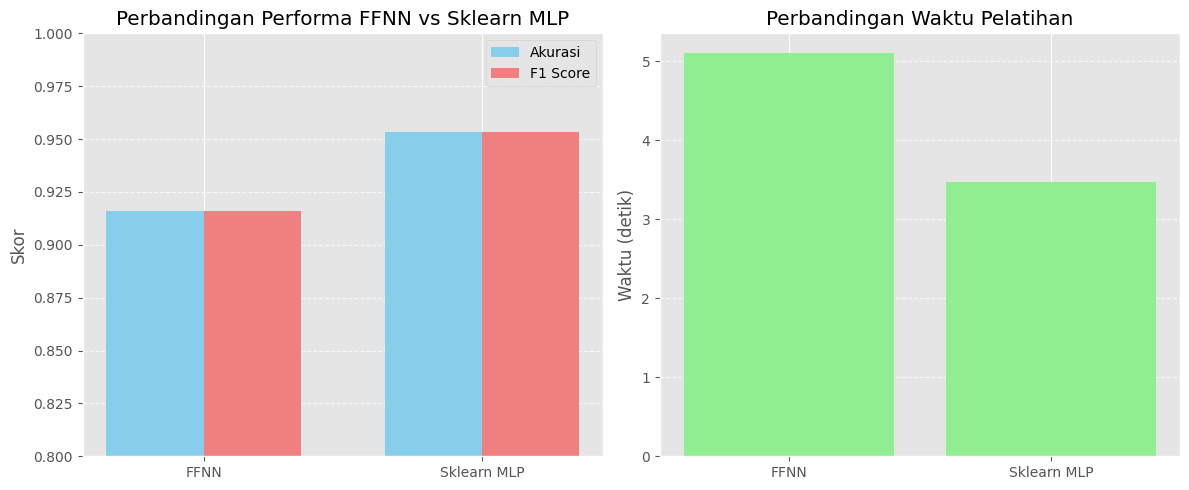

In [70]:
# Visualisasi perbandingan
plt.figure(figsize=(12, 5))

# Plot akurasi dan F1 score
plt.subplot(1, 2, 1)
models = ['FFNN', 'Sklearn MLP']
accuracies = [ffnn_accuracy, sklearn_accuracy]
f1_scores = [ffnn_f1, sklearn_f1]

x = np.arange(len(models))
width = 0.35
plt.bar(x - width/2, accuracies, width, label='Akurasi', color='skyblue')
plt.bar(x + width/2, f1_scores, width, label='F1 Score', color='lightcoral')
plt.title('Perbandingan Performa FFNN vs Sklearn MLP')
plt.xticks(x, models)
plt.ylabel('Skor')
plt.ylim(0.8, 1.0)  # Sesuaikan jika diperlukan
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot waktu pelatihan
plt.subplot(1, 2, 2)
training_times = [ffnn_training_time, sklearn_training_time]
plt.bar(models, training_times, color='lightgreen')
plt.title('Perbandingan Waktu Pelatihan')
plt.ylabel('Waktu (detik)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()